## Initialize HW and constants

In [2]:
import sys
sys.path.append("gpib_instrument_control")
import hp_3478a
import hp_8700_series_vna
import numpy as np
import time
import yig_controller_test
import matplotlib.pyplot as plt
import scipy.io as sio
import skrf.network
import yig_controller_test


plt.rcParams['figure.figsize'] = [15, 10]

#Instruments and devices
yigControllerPort='/dev/ttyUSB0'
vna = hp_8700_series_vna.Hp8753A()
curMeter = hp_3478a.Hp3478A()
yc = yig_controller_test.YigController(yigControllerPort)


Waiting for init... Done


In [3]:
#Constants and auxillary functions
fMin=np.array([0.6, 1, 2, 4, 8, 12])*1e9
fMax=np.array([1,   2, 4, 8, 12, 16])*1e9
yigDriver=yc.yigA
switch=yc.switchA


hardwareDescription='Yig filters moved to source side of transistor and 9v yig voltage regulator'
hardwareRevision='2.2'

#reset yig filters
yc.yigB.set(0,0)
yc.yigA.set(6,0)
yc.yigB.set(7,0)

if yigDriver==yc.yigA:
    driverChannel='A'
if yigDriver==yc.yigB:
    driverChannel='B'
    
def revFileName(baseName):
    global hardwareRevision
    return '%s_channel_%s_rev_%s.mat'%(baseName, driverChannel, hardwareRevision)

def saveData(baseName, baseData):
    global hardwareDescription
    global hardwareRevision
    dataToSave=baseData;
    dataToSave['hardwareDescription']=hardwareDescription
    sio.savemat(revFileName(baseName), dataToSave)

def loadData(baseName):
    global hardwareRevision
    return sio.loadmat(revFileName(baseName))
    

Writing=> YIG B 0 0

Writing=> YIG A 6 0

Writing=> YIG B 7 0



## Measure current tuning ranges

In [3]:
wr = np.linspace(-32768, 32767, 128, dtype=np.int16)
yigChs = range(6)

zeros = []
channels=[]
currentMtx = None;
for c in yigChs:
    yigDriver.set(c, wr[0])
    time.sleep(5);
    current=[]
    for w in wr:
        yigDriver.set(c, w);
        time.sleep(0.5)
        for i in range(3):
            curMeter.readValue()
        current.append(curMeter.readValue())
    channels.append(current)
    currentMtx = yig_controller_test.stackVector(currentMtx, current)
    yigDriver.set(6, 0)
    time.sleep(3)
    zeros.append(curMeter.readValue())

saveData('current_sweep', {'current':currentMtx, 'yigChs':yigChs, 'tuningWordRange': wr});


In [4]:
import scipy.io as sio
saveData('yig_filter_driver_current_data', {'zeros':zeros, 'channels':channels, 'wr':wr})

In [5]:
d=loadData('yig_filter_driver_current_data')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

In [6]:
print(zeros)

[0.082113 0.241526 0.283323 0.46811  1.11795  0.81037 ]


Filter 0 has current from -0.075700 to -0.000718 [A] in control word range -21932 - 32250 [LSB]
Filter 1 has current from -0.222620 to -0.002101 [A] in control word range -21932 - 32250 [LSB]
Filter 2 has current from -0.261103 to -0.002450 [A] in control word range -21932 - 32250 [LSB]
Filter 3 has current from -0.423763 to -0.001630 [A] in control word range -21932 - 22446 [LSB]
Filter 4 has current from -1.029946 to -0.009580 [A] in control word range -21932 - 32250 [LSB]
Filter 5 has current from -0.722162 to -0.000240 [A] in control word range -21932 - 16254 [LSB]


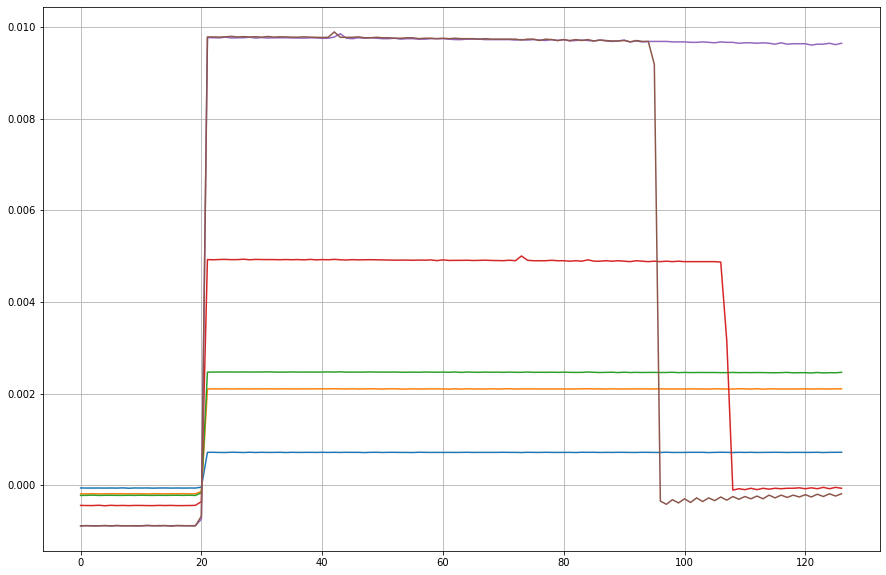

In [7]:
charr = np.array(channels)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

class FilterParameters:
    def __init__(self, lc, hc, lw, hw):
        self.lc=lc
        self.hc=hc
        self.lw=lw
        self.hw=hw

        
fParams=[]
for i in range(len(zeros)):
    #avgd = moving_average(np.diff(charr[i,:]), 10)
    avgd = np.diff(charr[i,:])
    plt.plot(avgd)
    plt.grid(True)
    idxs = np.where(avgd>0.0002);
    mii=idxs[0][0]
    mai=idxs[0][-1]
    zc = zeros[i]
    mic=charr[i,mii]-zc
    mac=charr[i,mai]-zc
    #print(idxs[0])
    print("Filter %i has current from %f to %f [A] in control word range %d - %d [LSB]"%(i, mic, mac, wr[mii], wr[mai]))
    fParams.append(FilterParameters(mic, mac, wr[mii], wr[mai]))
    

## Coarse tuning

0.428050 to 1.471225 [GHz]
0.477725 to 4.302700 [GHz]
1.073825 to 7.084500 [GHz]
1.868625 to 8.177350 [GHz]
1.818950 to 19.453575 [GHz]
1.918300 to 16.820800 [GHz]


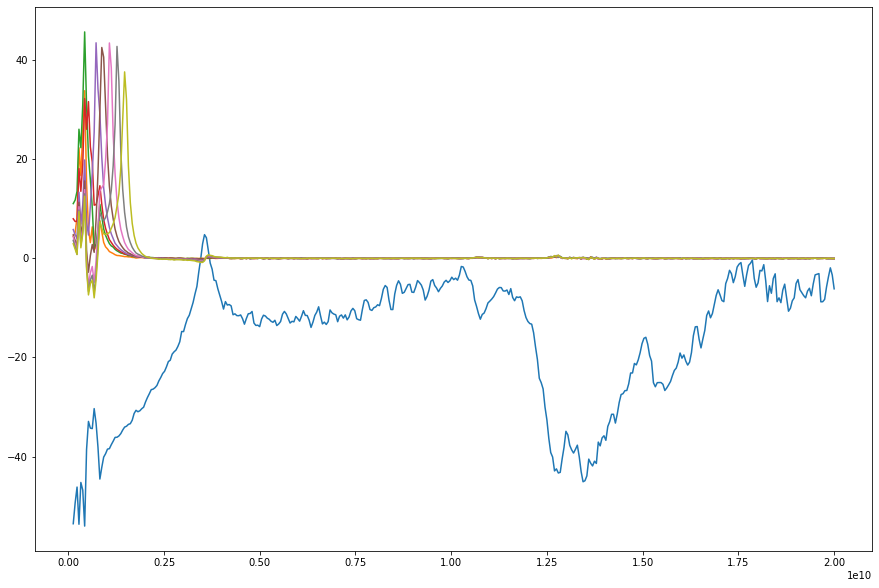

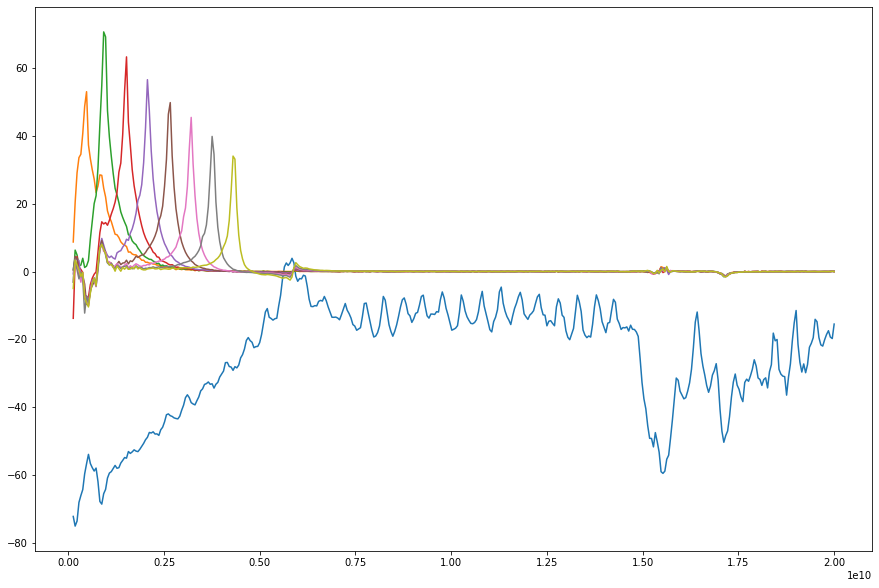

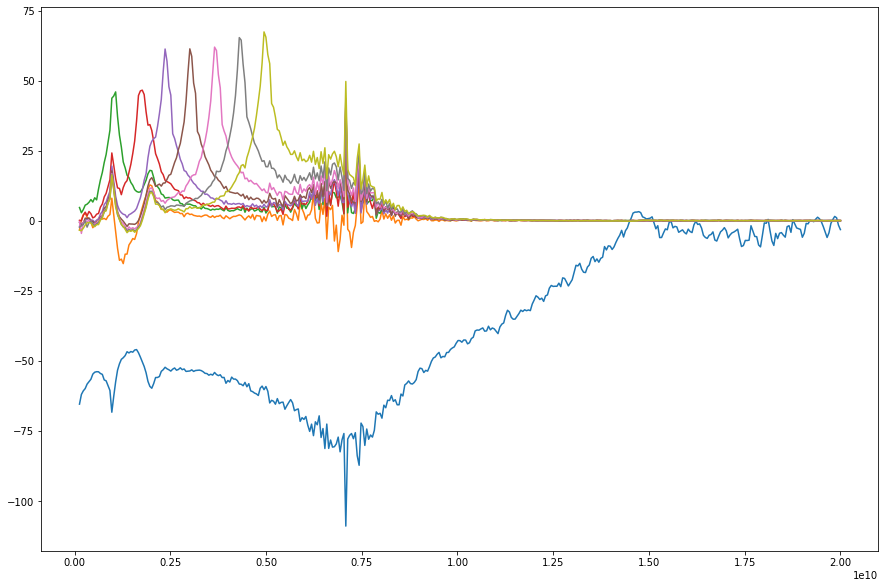

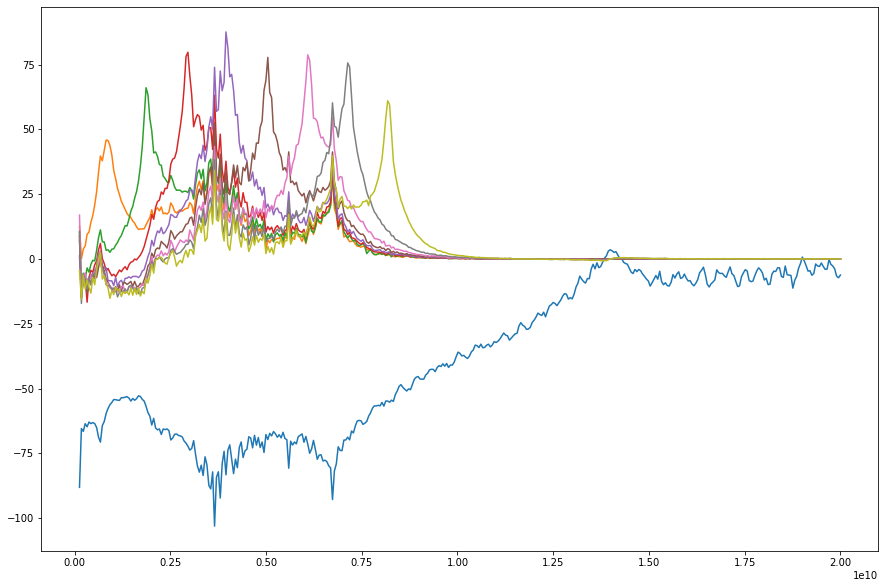

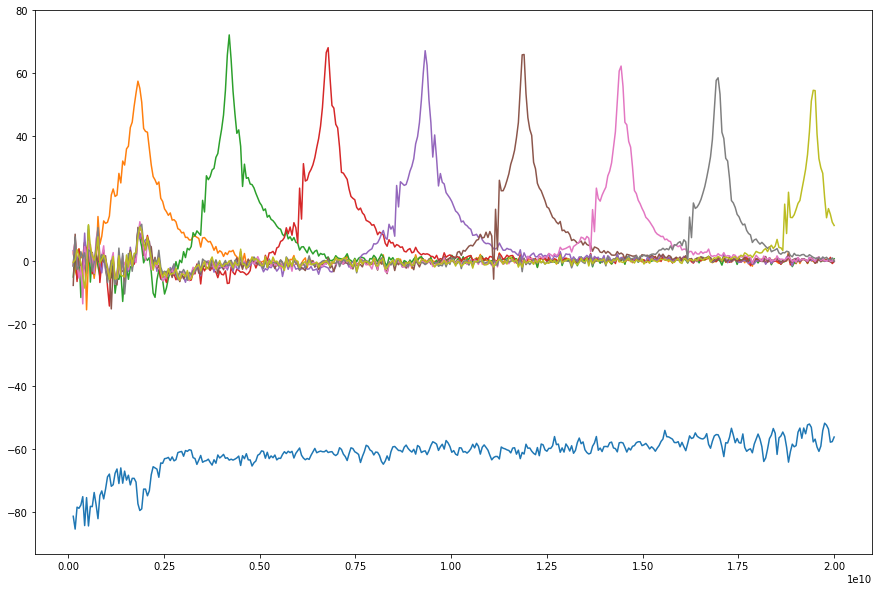

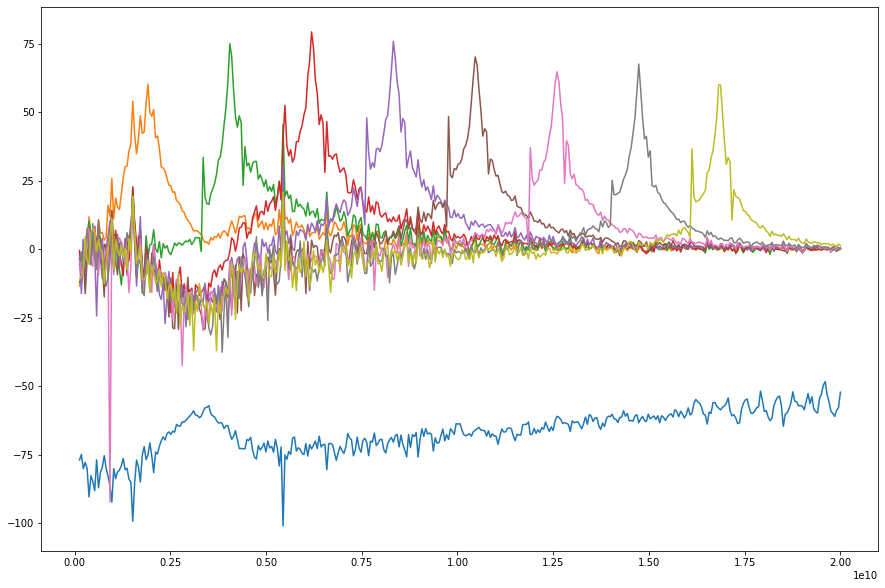

<Figure size 1080x720 with 0 Axes>

In [8]:
vna.setStartFrequency(130e6)
vna.setStopFrequency(20e9)
vna.setPoints(401)

fRanges=[]
for i in range(len(zeros)):
    #print("Filter", i )
    fp = fParams[i]
    switch.set(i+1)
    yigDriver.set(6, 0)
    fax = vna.frequencies()
    base = vna.readSParameter('S21')
    plt.plot(fax, 20*np.log10(np.abs(base)))
    sr = np.linspace(fp.lw, fp.hw, 8)
    freqs=[]
    
    for w in sr:
        yigDriver.set(i, int(w))
        time.sleep(1)
        t = vna.readSParameter('S21')
        #traces.append(t)
        delt = np.abs(t)/np.abs(base)
        freqs.append(fax[np.argmax(delt)])
        plt.plot(fax, 20*np.log10(delt))
    mif=np.min(freqs)
    maf=np.max(freqs)
    #print(freqs)
    #print(np.diff(freqs))
    fRanges.append((mif, maf))
    
    plt.figure()

for fmi, fma in fRanges:
    print("%f to %f [GHz]"%(fmi/1e9, fma/1e9))

import scipy.io as sio
saveData('yig_filter_driver_coarse_frequency', {'fRanges':fRanges})

In [9]:
#Get calibration data
import os.path

if not os.path.exists('cal_through.s2p'):
    calPar=vna.getHighResolutionNetwork(130e6, 20e9, 1e6)
    calPar.plot_s_db()
    calPar.write_touchstone('cal_through.s2p')

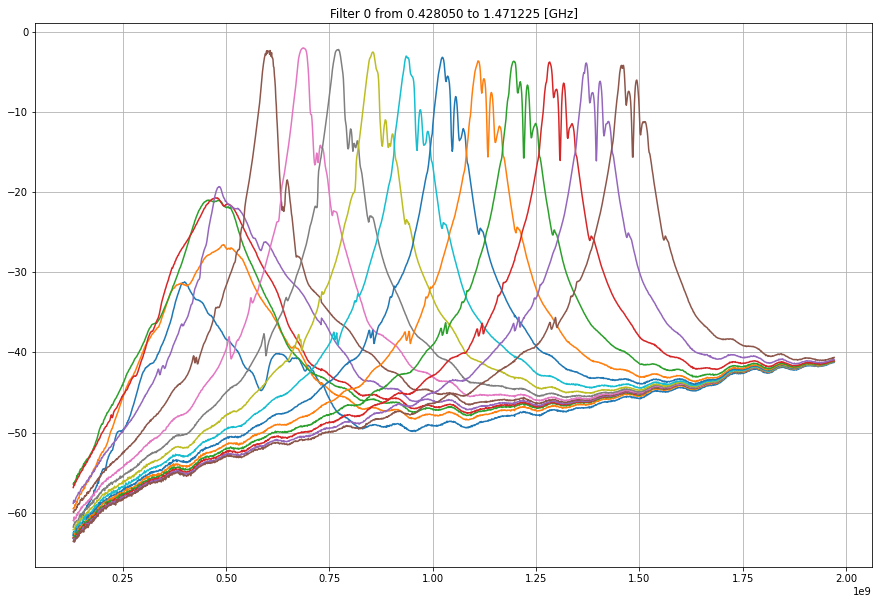

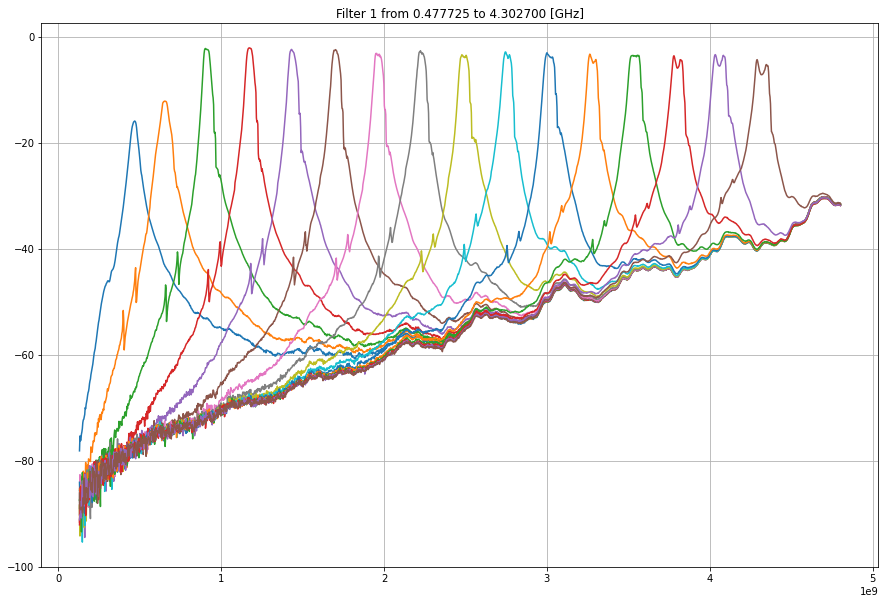

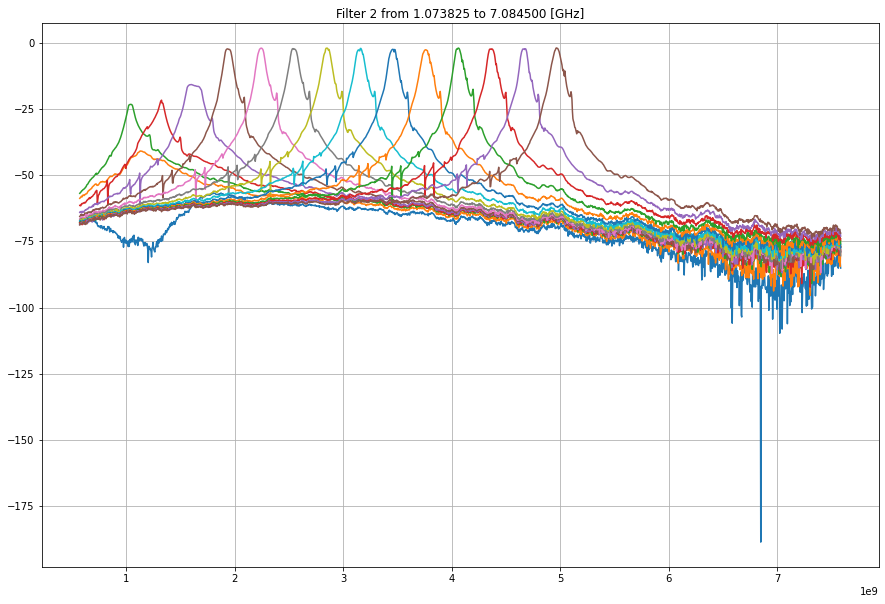

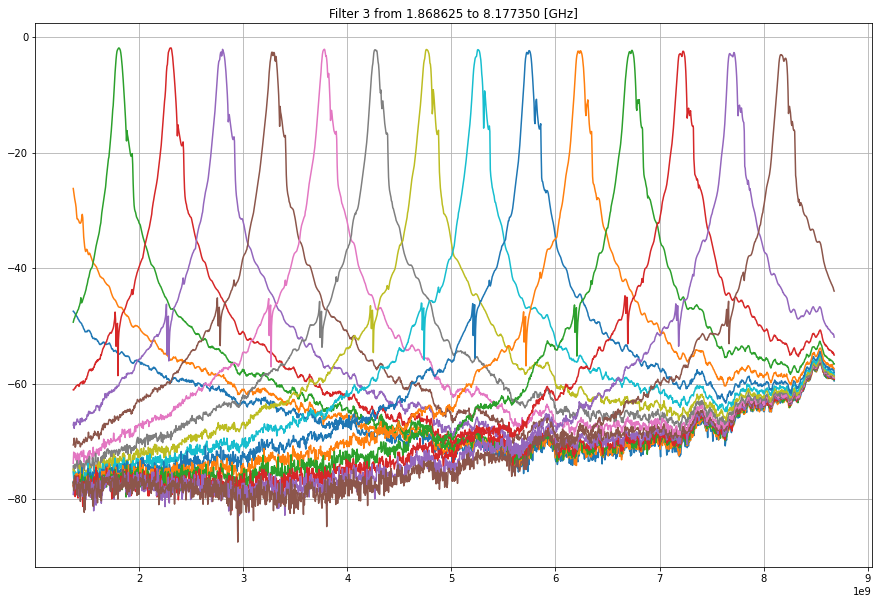

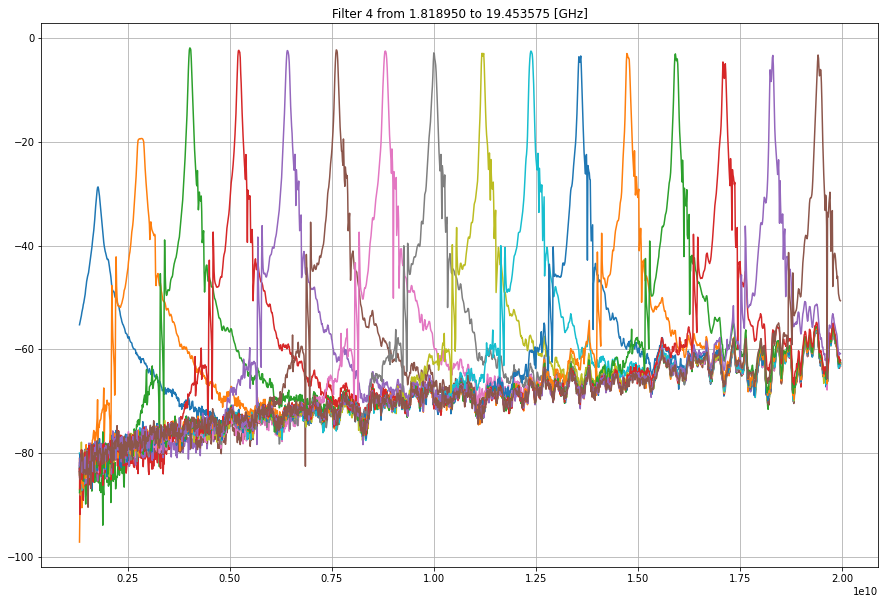

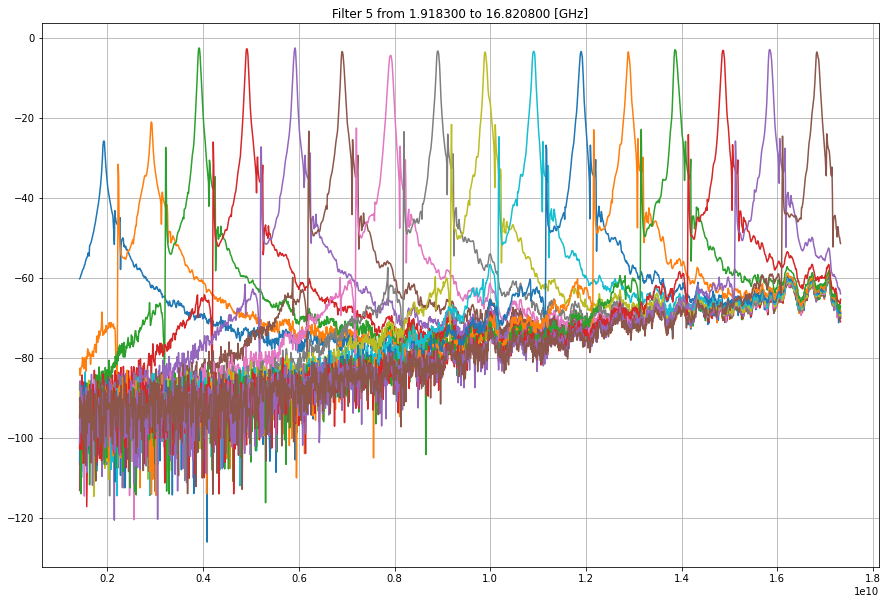

In [10]:
import skrf.network

calPar=skrf.network.Network('cal_through.s2p')
d=loadData('yig_filter_driver_current_data')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

d2=loadData('yig_filter_driver_coarse_frequency')
fRanges=d2['fRanges']
#print(fRanges)
#print(channels)
#print(wr)

def inter(fd, fa, a):
    afd=np.interp(fd, fa, a)
    return afd
    
filterMeas={}
for i in range(len(zeros)):
    switch.set(i+1)
    fsta=fRanges[i,0]-500e6
    fsta=np.max((fsta, 130e6))
    fsto=fRanges[i,1]+500e6
    fsto=np.min((fsto, 20e9))
    vna.setStartFrequency(fsta)
    vna.setStopFrequency(fsto)
    vna.setPoints(1601)
    vwr = np.linspace(fParams[i].lw, fParams[i].hw, 16)
    plt.figure()
    plt.title("Filter %d from %f to %f [GHz]"%(i, fRanges[i,0]/1e9, fRanges[i,1]/1e9))
    thisFilterMeas={}
    thisFilterMeas['words']=[]
    thisFilterMeas['traces']=[]
    thisFilterMeas['frequencies']=[]
    thisFilterMeas['calData']=[]
    for w in vwr:
        yigDriver.set(i, int(w))
        time.sleep(0.5)
        tr = vna.readSParameter('S21')
        fr = vna.frequencies()
        cai=inter(fr, calPar.f, np.abs(calPar.s[:,1,0]))
        #nf, npar = norm(calPar.f, np.abs(calPar.s[:,0,1]), fr, np.abs(tr))
        #plt.plot(nf, npar)
        plt.plot(fr, 20*np.log10(np.abs(tr)/cai))
        thisFilterMeas['words'].append(w)
        thisFilterMeas['traces'].append(tr)
        thisFilterMeas['frequencies'].append(fr)
        thisFilterMeas['calData'].append(cai)
        #plt.plot(fr, cai)
    filterMeas[i] =  thisFilterMeas
    plt.grid(True)
    plt.show()
    yigDriver.set(6, 0)    
    

In [11]:

kvec=[]
mvec=[]
for i in range(len(zeros)):
    thisFilter=filterMeas[i]
    words = thisFilter['words']
    traces = thisFilter['traces']
    frequencies = thisFilter['frequencies'][0]
    cals = thisFilter['calData']
    fildat=[]
    for trace, w, cal in zip(traces, words, cals):
        tDat = 20*np.log10(np.abs(trace)/np.abs(cal))
        i=np.argmax(tDat)
        if(tDat[i]>-5):
            fildat.append((int(w), frequencies[i]/1e6, tDat[i]))

    j=int(len(fildat)/5.0)
    jj=int(4*len(fildat)/5.0)
    m=int((j+jj)/2)
    dw=fildat[jj][0]-fildat[j][0]
    df=fildat[jj][1]-fildat[j][1]
    filK=df/dw
    ms=[]
    for m in range(len(fildat)):
        filM=fildat[m][1]-fildat[m][0]*filK
        ms.append(filM)
    filM=np.mean(ms)
    print("Filter parameter for filter %d is k %.3f [MHz/LSB] m is %.3f[LSB]"%(i, filK, filM))
    kvec.append(filK)
    mvec.append(filM)

coarseFilter={'k':kvec, 'm':mvec}
saveData('coarse_filter_parameters', coarseFilter)
        

Filter parameter for filter 1153 is k 0.024 [MHz/LSB] m is 692.360[LSB]
Filter parameter for filter 1425 is k 0.072 [MHz/LSB] m is 1976.554[LSB]
Filter parameter for filter 1002 is k 0.085 [MHz/LSB] m is 2255.413[LSB]
Filter parameter for filter 1488 is k 0.166 [MHz/LSB] m is 4472.329[LSB]
Filter parameter for filter 1553 is k 0.328 [MHz/LSB] m is 8880.906[LSB]
Filter parameter for filter 1550 is k 0.390 [MHz/LSB] m is 10504.204[LSB]


## Measure drift

In [12]:
import time
coarseFilter=loadData('coarse_filter_parameters')
mvec=coarseFilter['m'][0]
kvec=coarseFilter['k'][0]


def computeWord(fTarget, k, m):
    return (fTarget/1e6-m)/k

s21Drift=None
currentDrift=None

dataDict={}

def measureDrifts():
    for a in range(10):
        curMeter.readValue()
    t0=time.time()
    t00=t0
    fmax=[]
    curr=[]
    phase=[]
    sFreq = None
    sMat = None
    timeVec = []
    for j in range(10):
        
        t0=t00+10*j
        while time.time() < t0:
            pass
        f=vna.frequencies()
        curr.append(curMeter.readValue())
        t=vna.readSParameter('S21')
        fmax.append(f[np.argmax(np.abs(t))])
        phase.append(np.angle(t[int(len(t)/2)]))
        sFreq = f;
        sMat = yig_controller_test.stackVector(sMat, t)
        timeVec.append(t0)
    return timeVec, f, curr, phase, sMat, fmax
    

for i in range(6):
    print("Measuring filter", i)
    k = kvec[i]
    m = mvec[i]
    switch.set(i+1)
    keyBase = 'yigFilter%d'%(i)
    for tf, keySub in zip([fMin[i], fMax[i], fMin[i]], ['Low', 'High', 'LowAgain']):
        yigDriver.set(i, int(computeWord(tf, k, m)))
        vna.setStartFrequency(tf-100e6)
        vna.setStopFrequency(tf+100e6) 
        timeVec, f, curr, phase, sMat, fmax = measureDrifts()
        dataDict[keyBase+keySub+'Current']=curr 
        dataDict[keyBase+keySub+'Time']=timeVec
        dataDict[keyBase+keySub+'Frequency']=f
        dataDict[keyBase+keySub+'Phase']=phase
        dataDict[keyBase+keySub+'SMatrix']=sMat
        dataDict[keyBase+keySub+'MinimumLossFrequency']=fmax
        
        
saveData('filter_drift', dataDict)

Measuring filter 0
Measuring filter 1
Measuring filter 2
Measuring filter 3
Measuring filter 4
Measuring filter 5


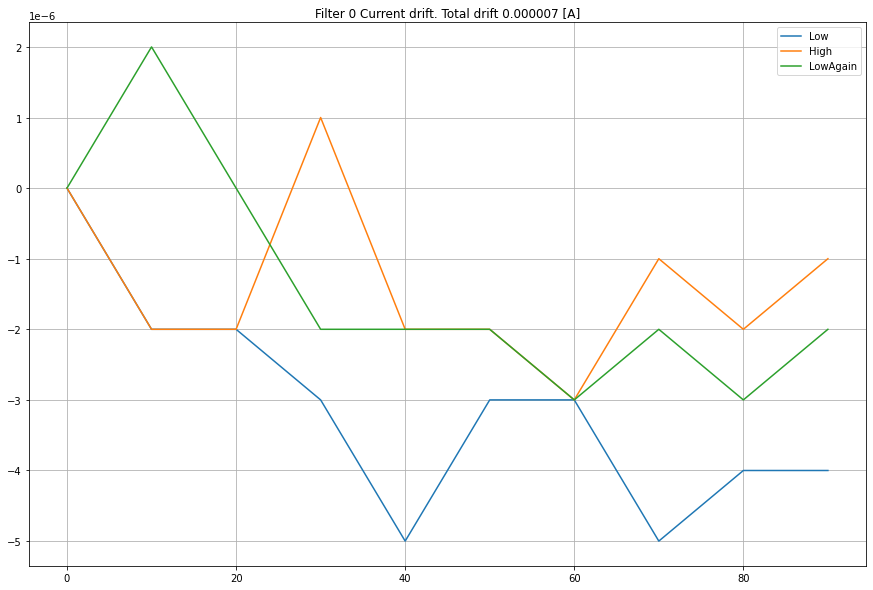

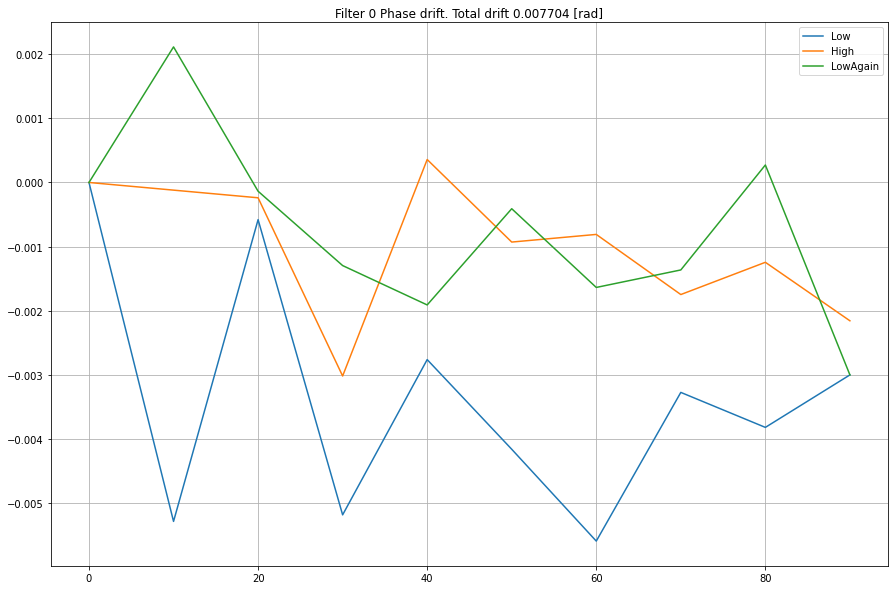

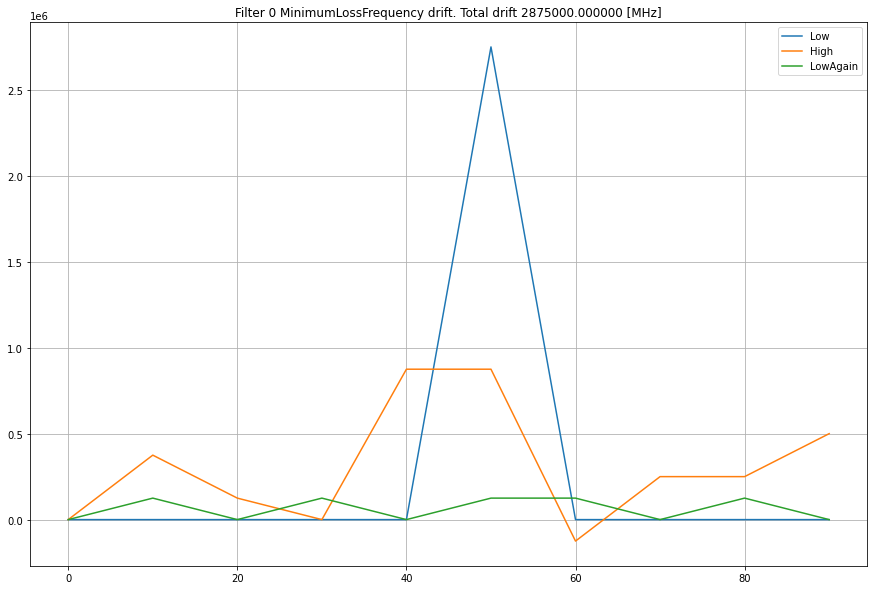

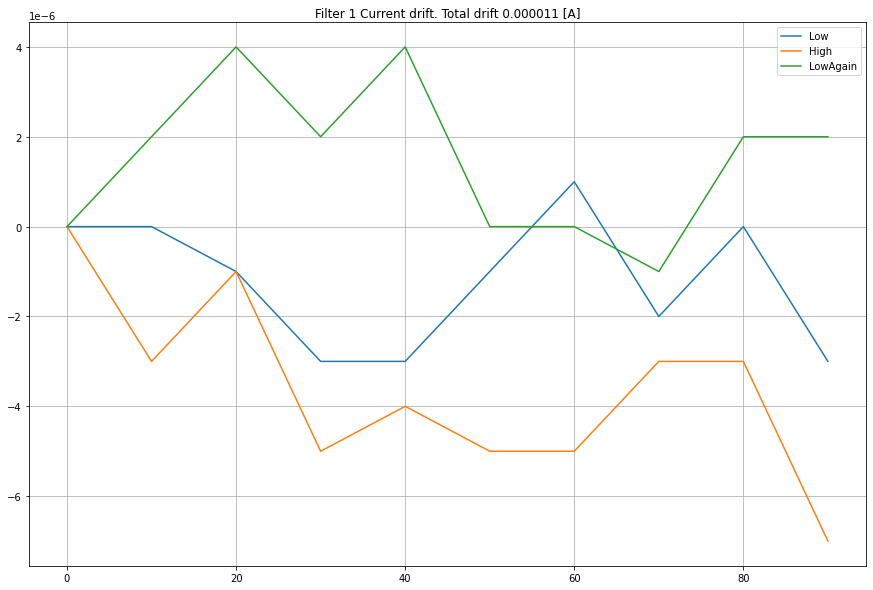

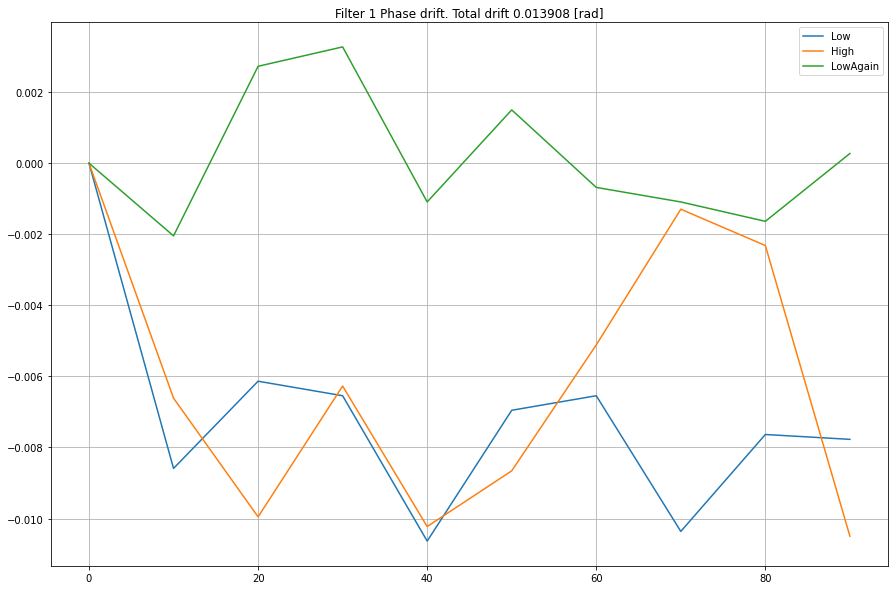

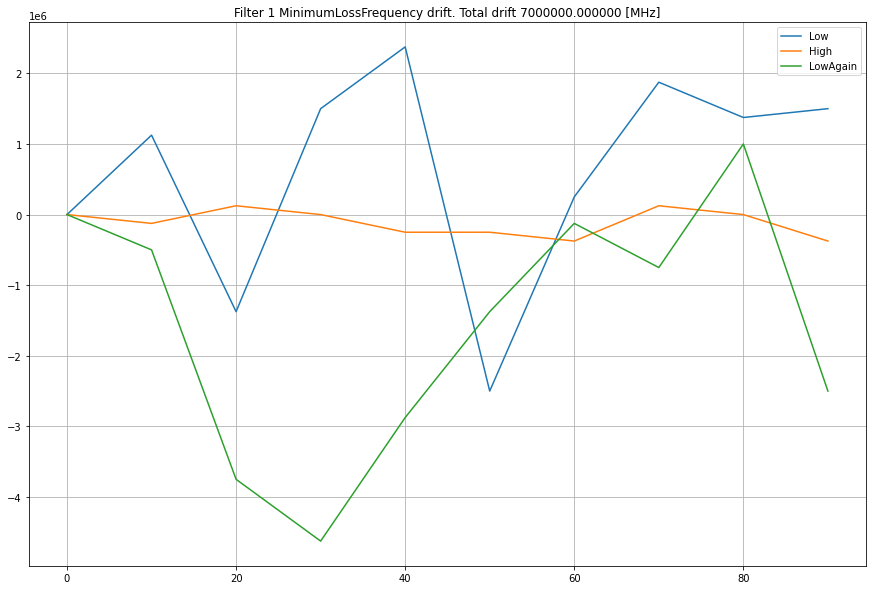

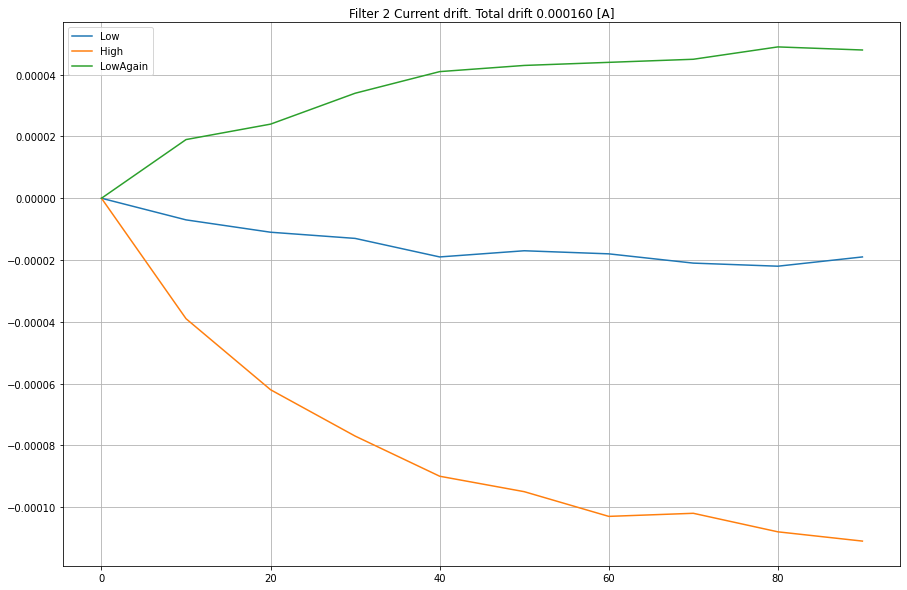

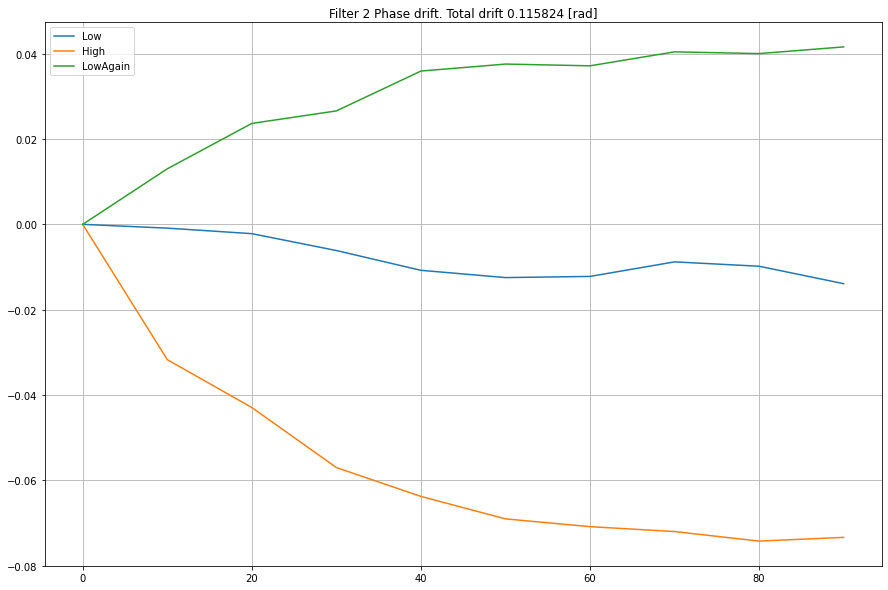

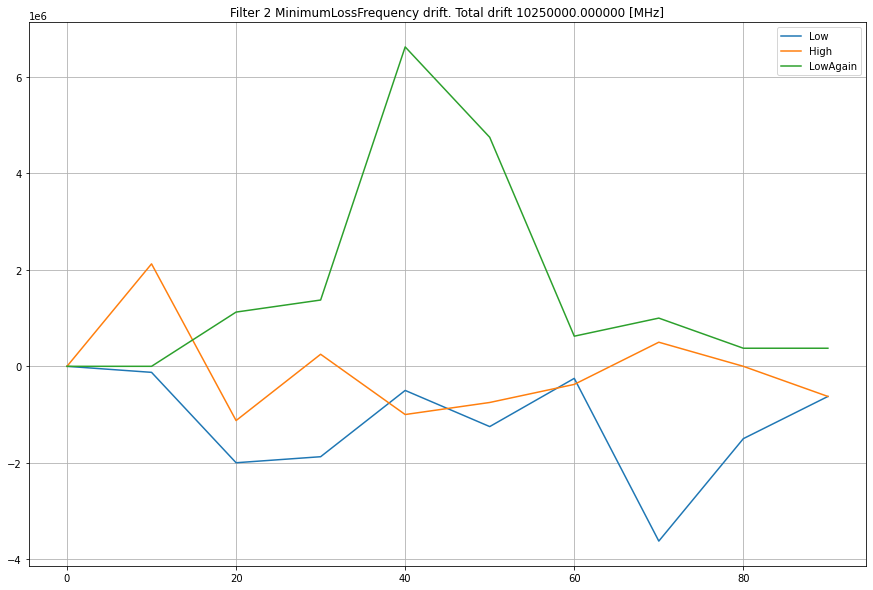

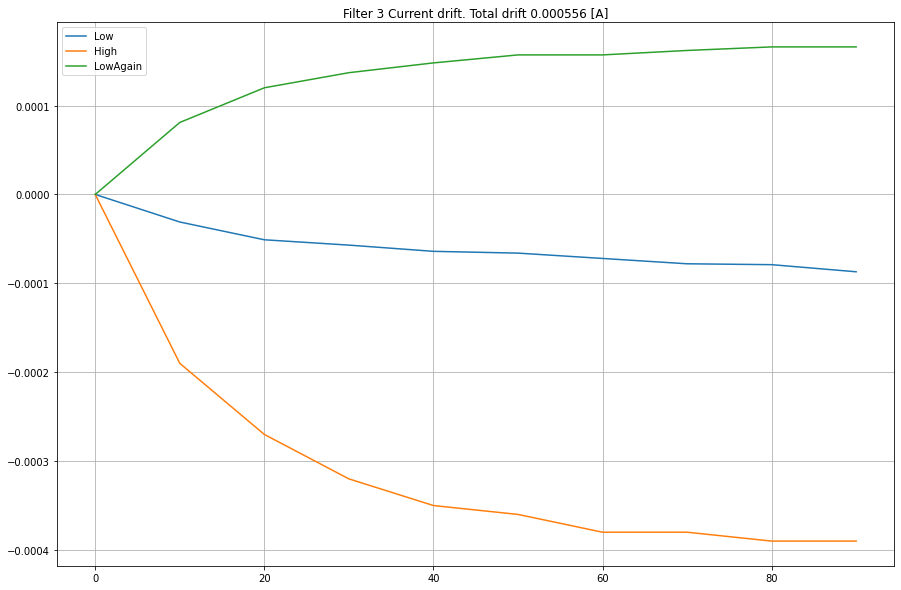

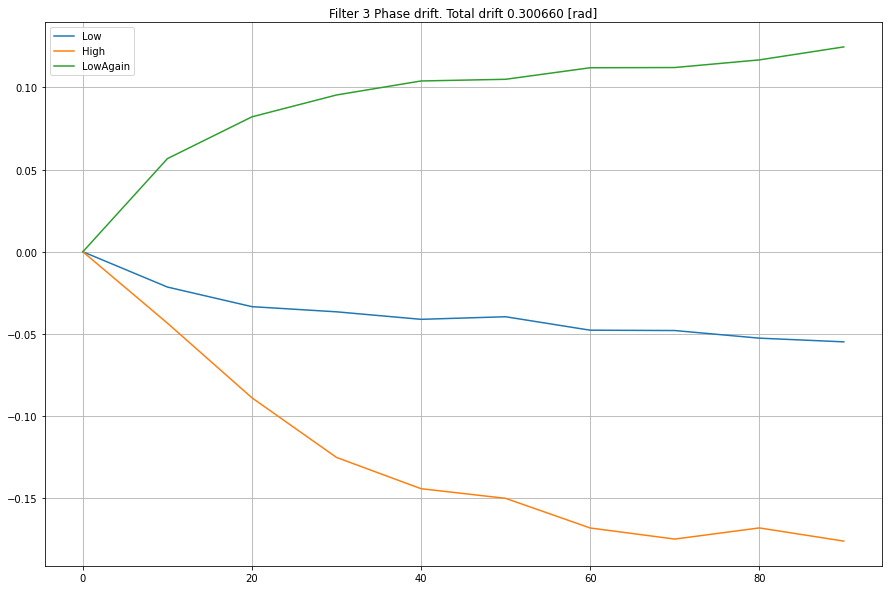

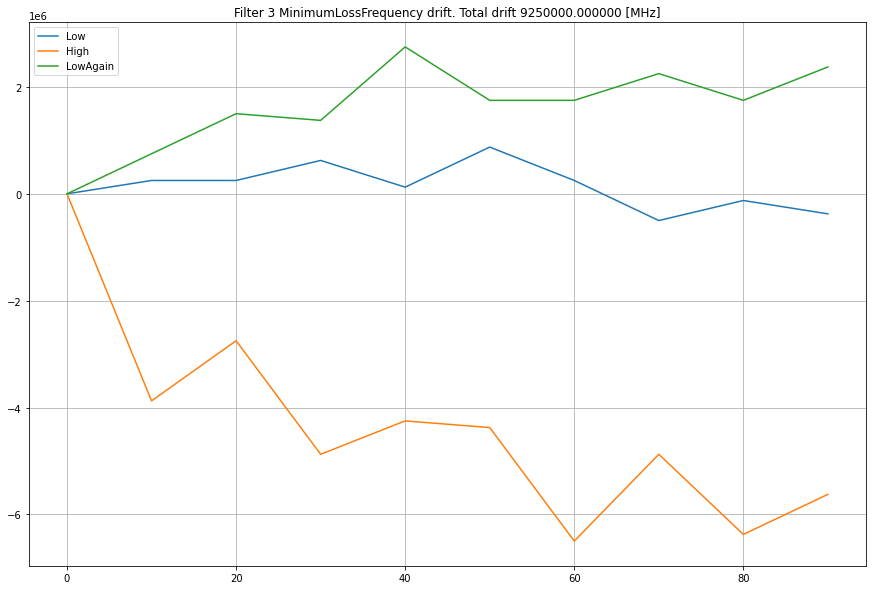

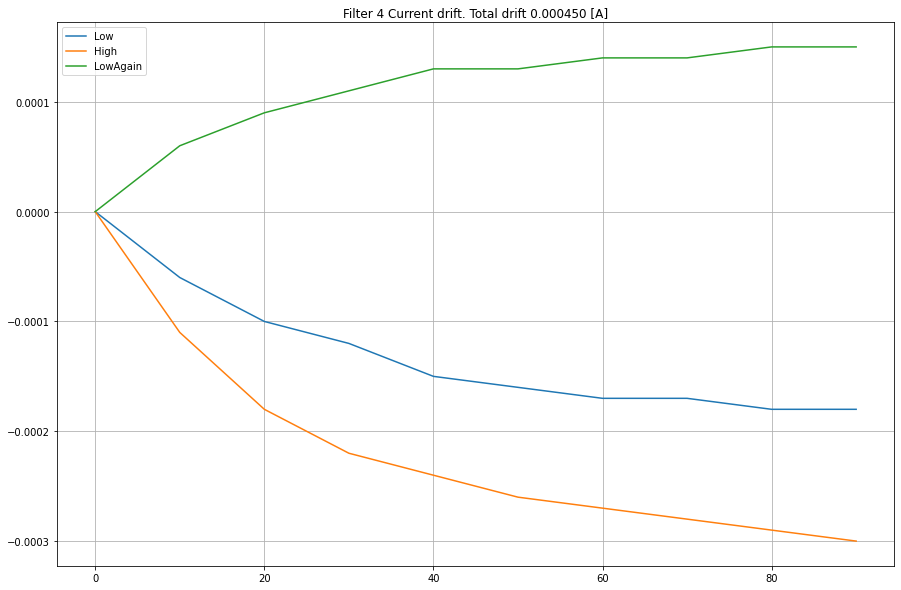

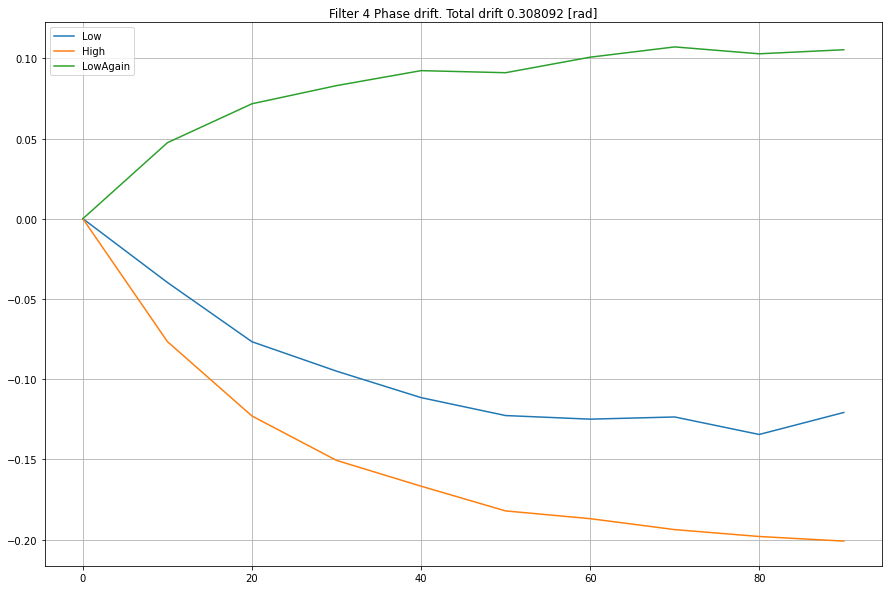

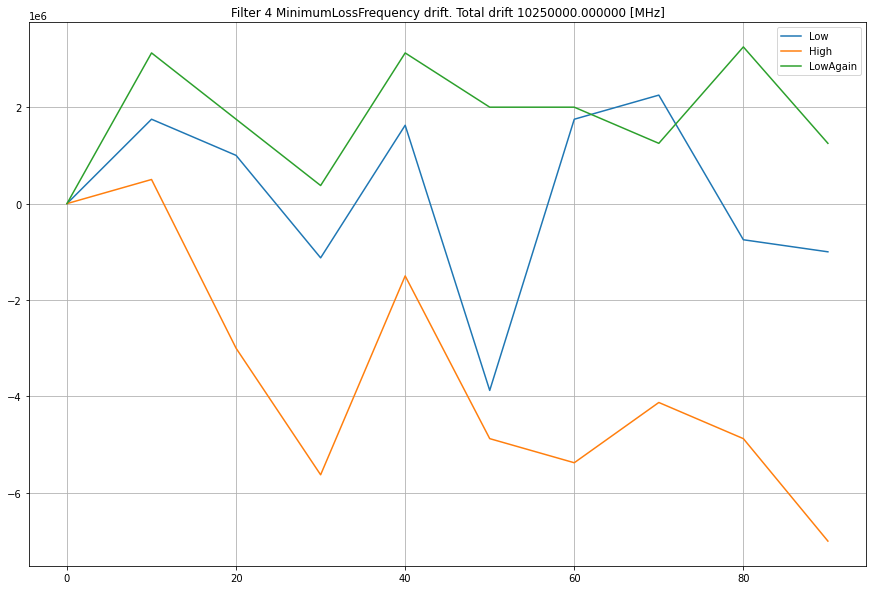

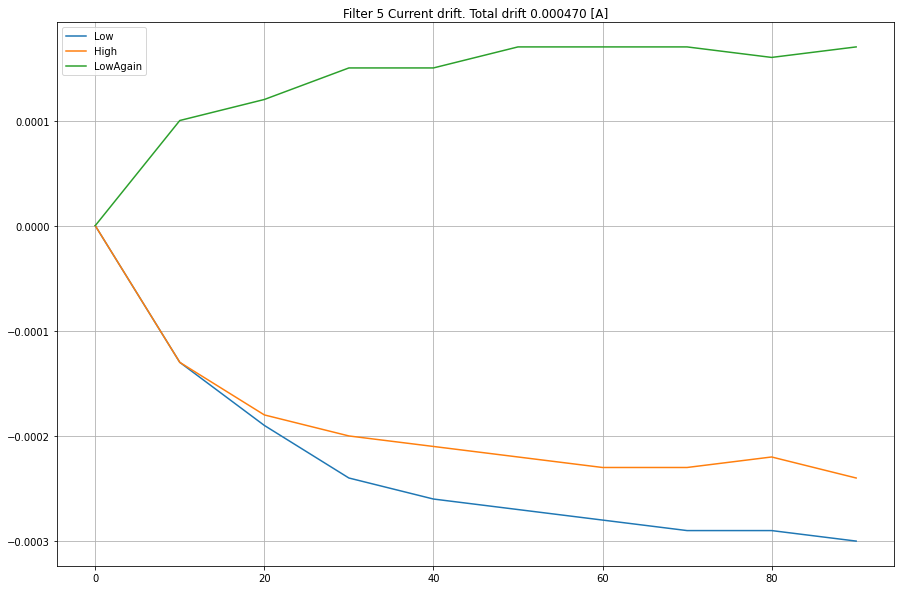

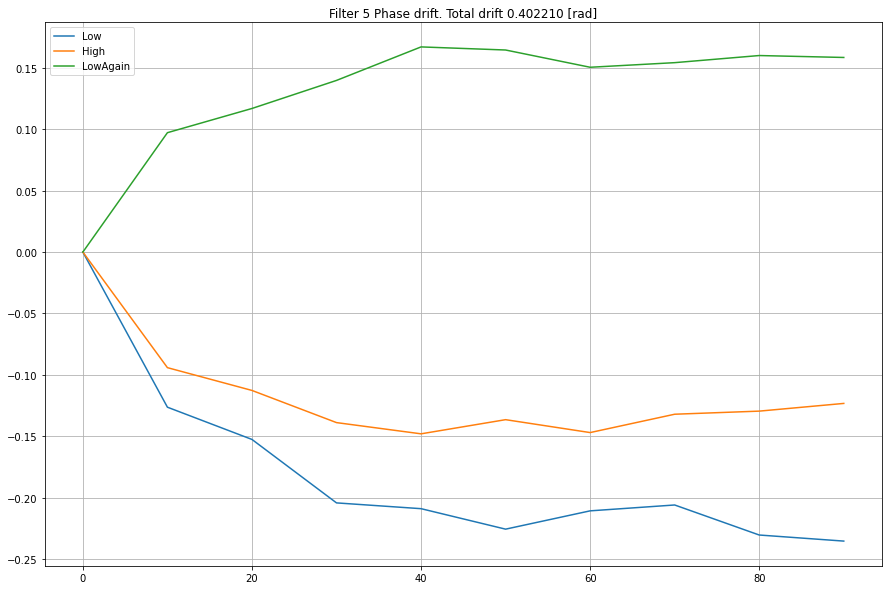

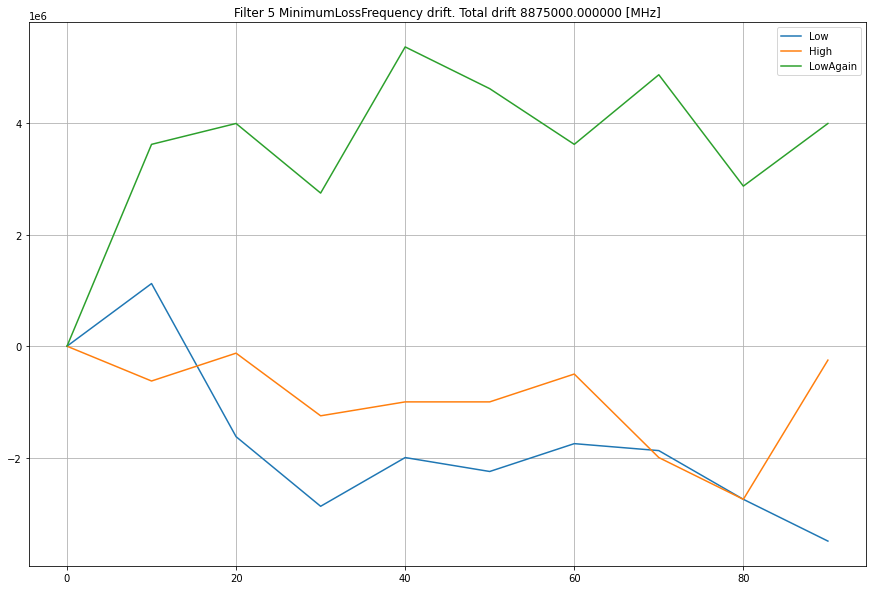

In [13]:
dd = loadData('filter_drift')

def plotParameter(i, par, unit):
    keyBase = 'yigFilter%d'%(i)
    plt.figure()
    
    minVal=None
    maxVal=None
    for keySub in ['Low', 'High', 'LowAgain']:
        data=dd[keyBase+keySub+par][0]
        timeData=dd[keyBase+keySub+'Time'][0]
        timeData=timeData-timeData[0]
        data=data-data[0]
        plt.plot(timeData, data, label=keySub)
        if minVal is None:
            minVal=min(data)
        else:
            minVal = min(minVal, min(data))
        if maxVal is None:
            maxVal=max(data)
        else:
            maxVal=max(maxVal, max(data))
        
    plt.title("Filter %d %s drift. Total drift %f [%s]"%(i, par, maxVal-minVal, unit))    
    plt.grid(True)
    plt.legend()
    plt.show()

for i in range(6):
    plotParameter(i, 'Current', 'A')
    plotParameter(i, 'Phase', 'rad')
    plotParameter(i, 'MinimumLossFrequency', 'MHz')
        
        
    

## Fine tuning of filter tuning parameters

In [5]:
a = loadData('coarse_filter_parameters')
import yig_controller_test
import yig_filter_model

ks = a['k'][0]
ms = a['m'][0]
filterBank = []
for i in range(len(ks)):
    filterBank.append(yig_controller_test.YigFilter(fMin[i], fMax[i], ms[i]*1e6, ks[i]*1e6, yc, i))
    
calMeas = skrf.network.Network('cal_through.s2p')

fix = yig_filter_model.SimpleS21Fixture(calMeas.f, calMeas.s[:, 1, 0])

yc.yigB.set(0,0)
yc.yigA.set(6,0)
yc.yigB.set(7,0)

def measureYigFilter(f):
    frequencies = np.linspace(f.flow, f.fhigh, 101)
    vna.setPoints(201)
    filterMap=None
    spanMap=None
    tuningWords=[]
    for fr in frequencies:
        f.tuneTo(fr, channel=yigDriver)
        tuningWords.append(f.computetTuningWord(fr))
        vna.setStartFrequency(fr-250e6)
        vna.setStopFrequency(fr+250e6)
        spar=vna.readSParameter('S21')
        fax = vna.frequencies()
        spanMap = yig_controller_test.stackVector(spanMap, fax)
        dePar=fix.deembedFrom(fax, spar)
        filterMap=yig_controller_test.stackVector(filterMap, dePar)
    plt.figure()
    plt.imshow(20*np.log10(np.abs(filterMap)))
    plt.colorbar()
    plt.show()
    return filterMap, tuningWords, frequencies, spanMap
        
                             
                             
    

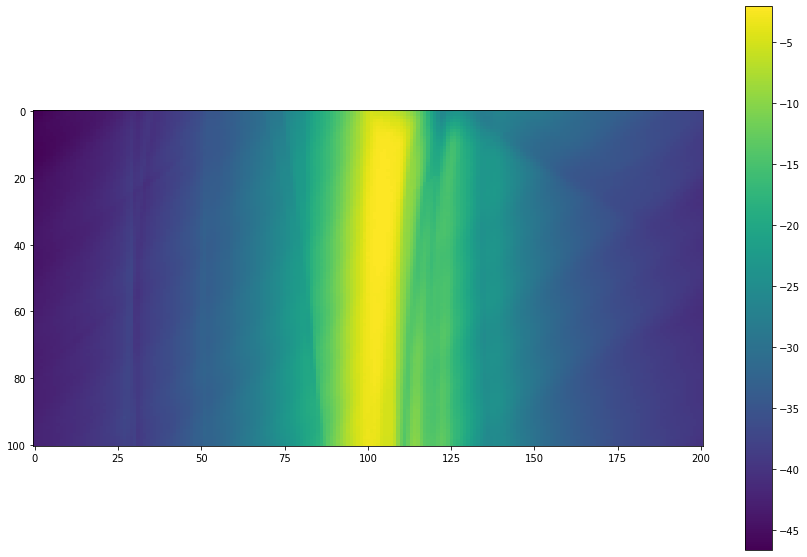

In [6]:
filter0Map, filter0TuningWords, filter0Frequencies, filter0SpanMap = measureYigFilter(filterBank[0])

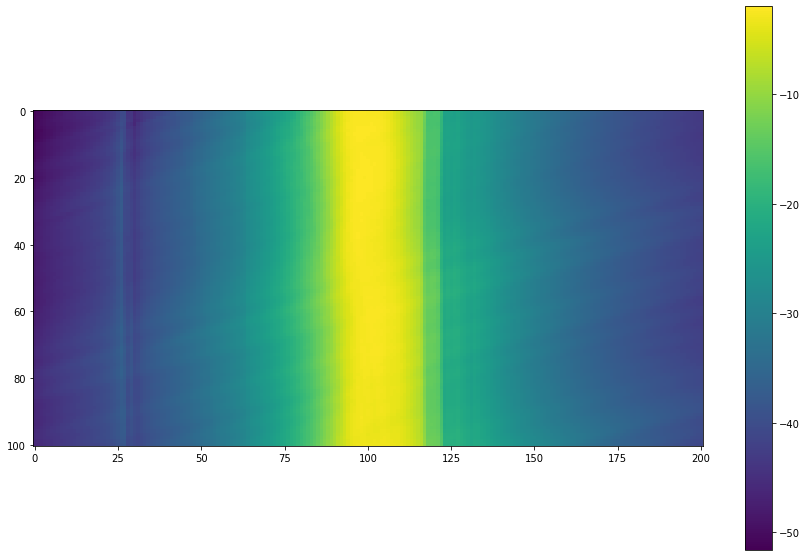

In [7]:
filter1Map, filter1TuningWords, filter1Frequencies, filter1SpanMap = measureYigFilter(filterBank[1])

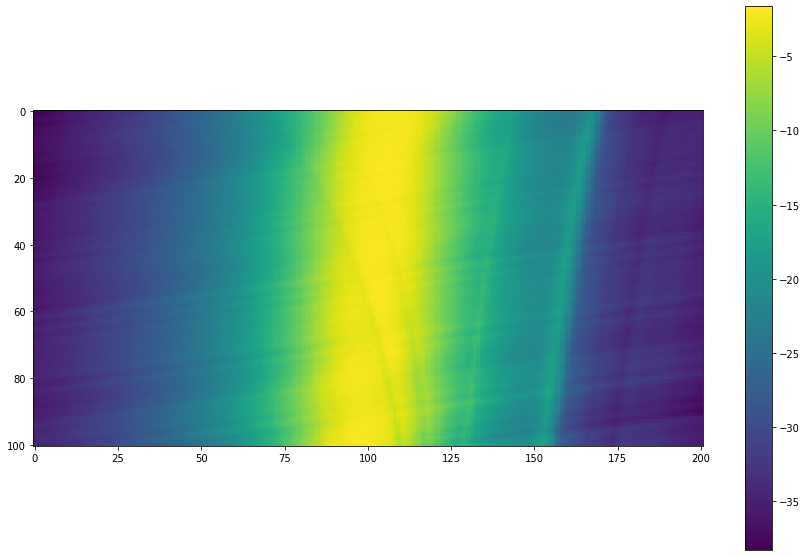

In [8]:
filter2Map, filter2TuningWords, filter2Frequencies, filter2SpanMap = measureYigFilter(filterBank[2])

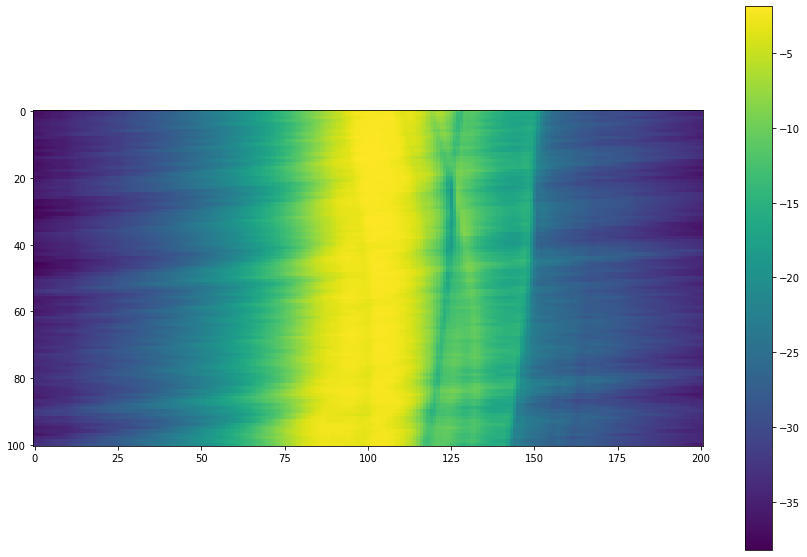

In [9]:
filter3Map, filter3TuningWords, filter3Frequencies, filter3SpanMap = measureYigFilter(filterBank[3])

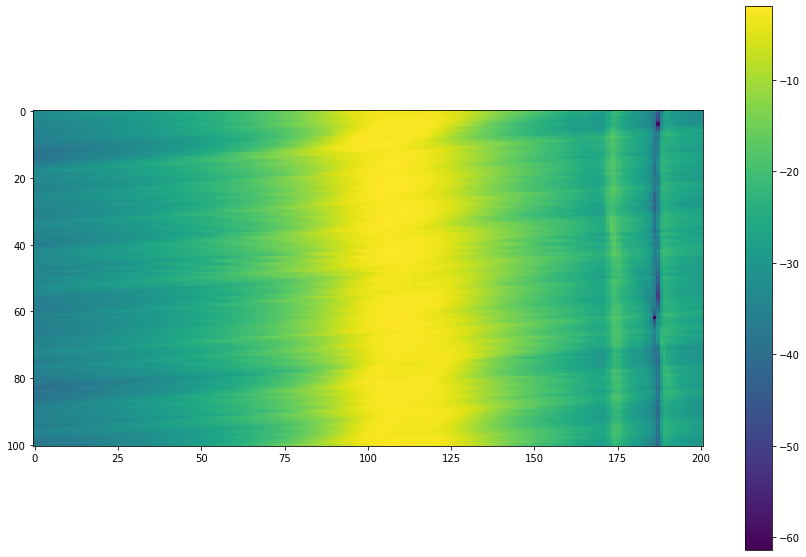

In [10]:
filter4Map, filter4TuningWords, filter4Frequencies, filter4SpanMap = measureYigFilter(filterBank[4])

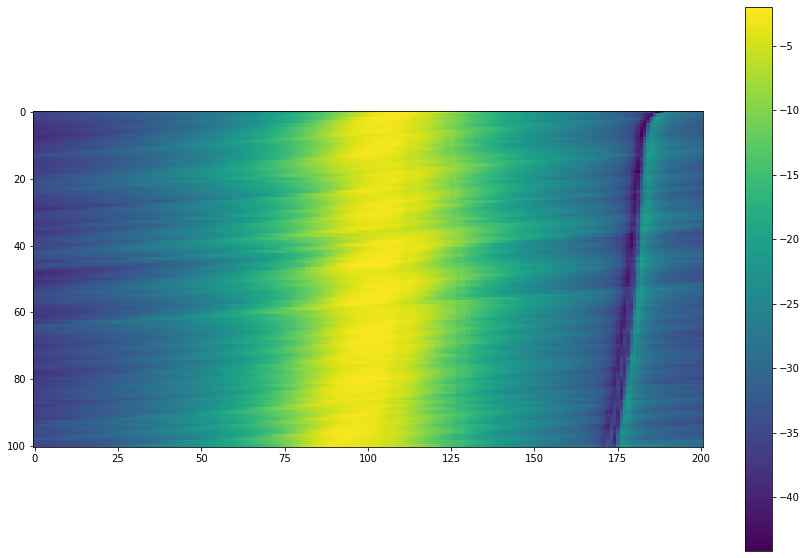

In [11]:
filter5Map, filter5TuningWords, filter5Frequencies, filter5SpanMap = measureYigFilter(filterBank[5])

In [12]:
saveDict={'filter0Map':filter0Map, 'filter0TuningWords':filter0TuningWords, 'filter0Frequencies':filter0Frequencies, 'filter0SpanMap':filter0SpanMap, 
          'filter1Map':filter1Map, 'filter1TuningWords':filter1TuningWords, 'filter1Frequencies':filter1Frequencies, 'filter1SpanMap':filter1SpanMap, 
          'filter2Map':filter2Map, 'filter2TuningWords':filter2TuningWords, 'filter2Frequencies':filter2Frequencies, 'filter2SpanMap':filter2SpanMap, 
          'filter3Map':filter3Map, 'filter3TuningWords':filter3TuningWords, 'filter3Frequencies':filter3Frequencies, 'filter3SpanMap':filter3SpanMap, 
          'filter4Map':filter4Map, 'filter4TuningWords':filter4TuningWords, 'filter4Frequencies':filter4Frequencies, 'filter4SpanMap':filter4SpanMap, 
          'filter5Map':filter5Map, 'filter5TuningWords':filter5TuningWords, 'filter5Frequencies':filter5Frequencies, 'filter5SpanMap':filter5SpanMap, }
saveData('coarse_tuning_fine_measurements', saveDict)

filter 0 Coarse k 0.023574952129377564 [MHZ/lsb] coarse m 692.3598863385345 [MHz]
filter 0 fine   k 0.023034627243764066 [MHZ/lsb] cfine  m 704.3939573926987 [MHz]
filter 1 Coarse k 0.07222935123661868 [MHZ/lsb] coarse m 1976.5536058393322 [MHz]
filter 1 fine   k 0.07282484605642375 [MHZ/lsb] cfine  m 1970.6741649540672 [MHz]
filter 2 Coarse k 0.08471003163498364 [MHZ/lsb] coarse m 2255.4127886880356 [MHz]
filter 2 fine   k 0.08362027713551867 [MHZ/lsb] cfine  m 2276.4698649839006 [MHz]
filter 3 Coarse k 0.1660761924882629 [MHZ/lsb] coarse m 4472.329102384347 [MHz]
filter 3 fine   k 0.16613543713831988 [MHZ/lsb] cfine  m 4477.160203141481 [MHz]
filter 4 Coarse k 0.3281753049249416 [MHZ/lsb] coarse m 8880.90581791405 [MHz]
filter 4 fine   k 0.32862568442880835 [MHZ/lsb] cfine  m 8898.705759672932 [MHz]
filter 5 Coarse k 0.3904306337567108 [MHZ/lsb] coarse m 10504.203611719378 [MHz]
filter 5 fine   k 0.3881885354619618 [MHZ/lsb] cfine  m 10520.738265184726 [MHz]


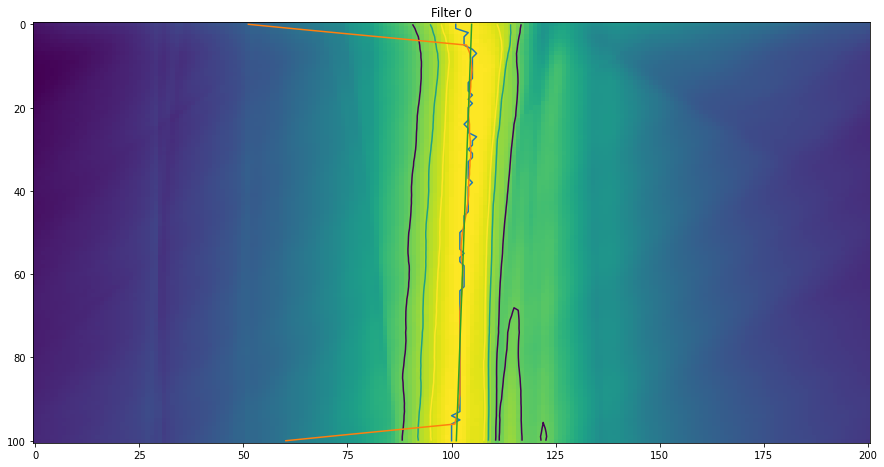

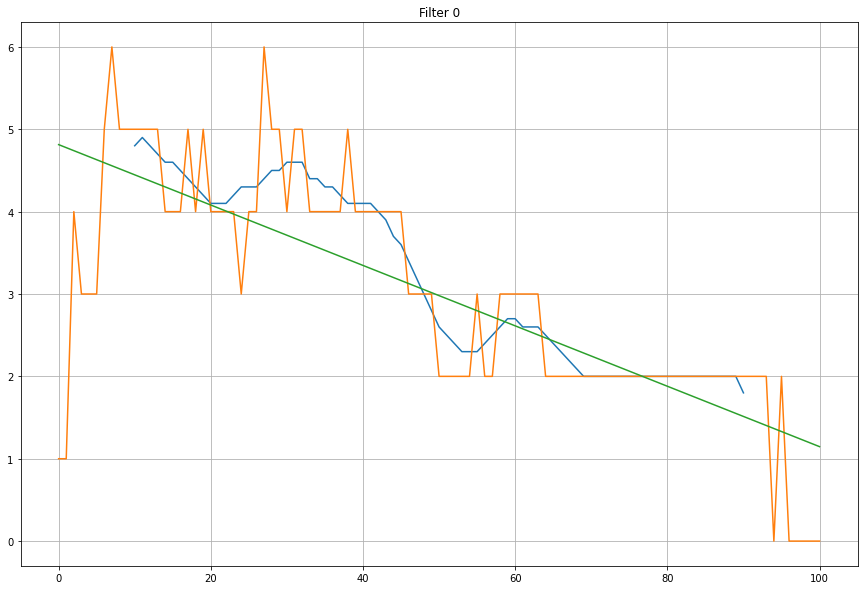

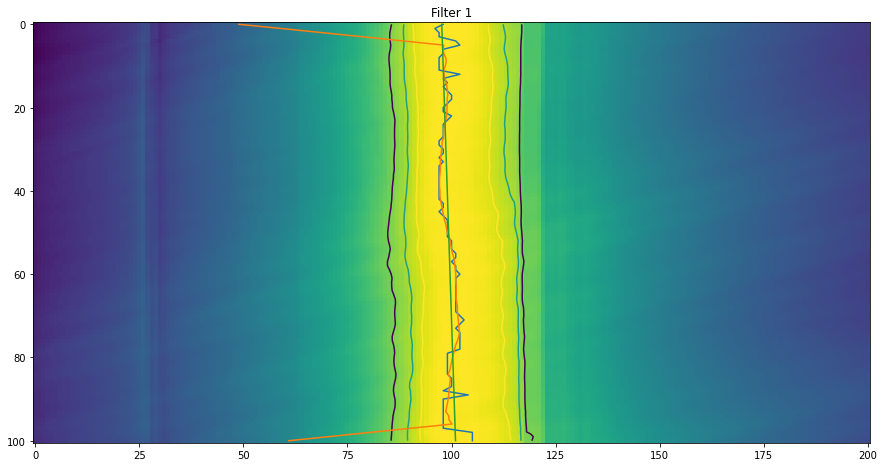

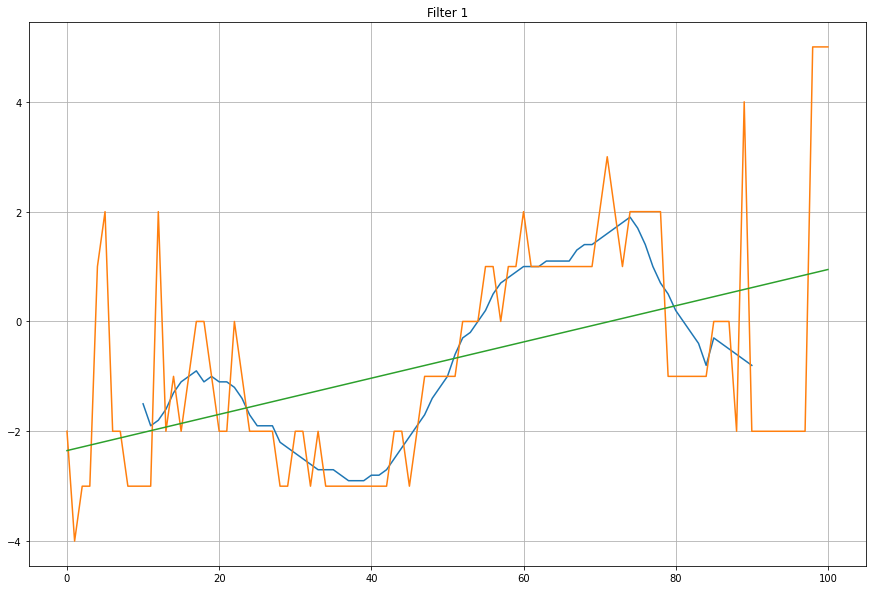

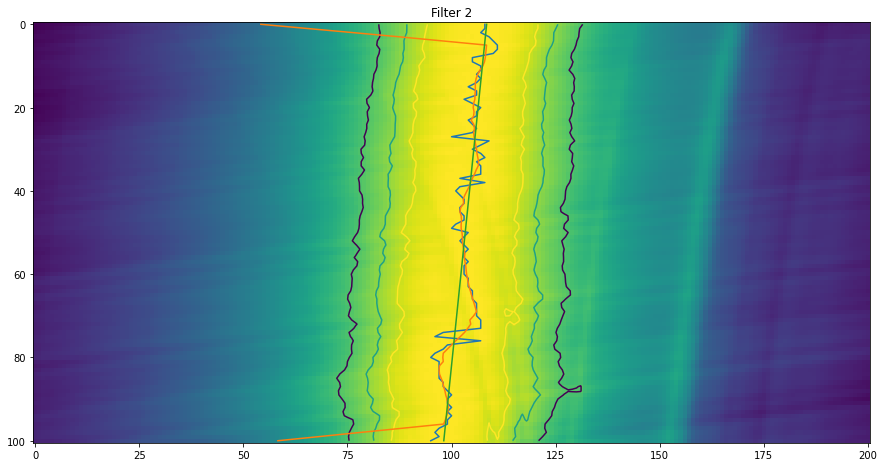

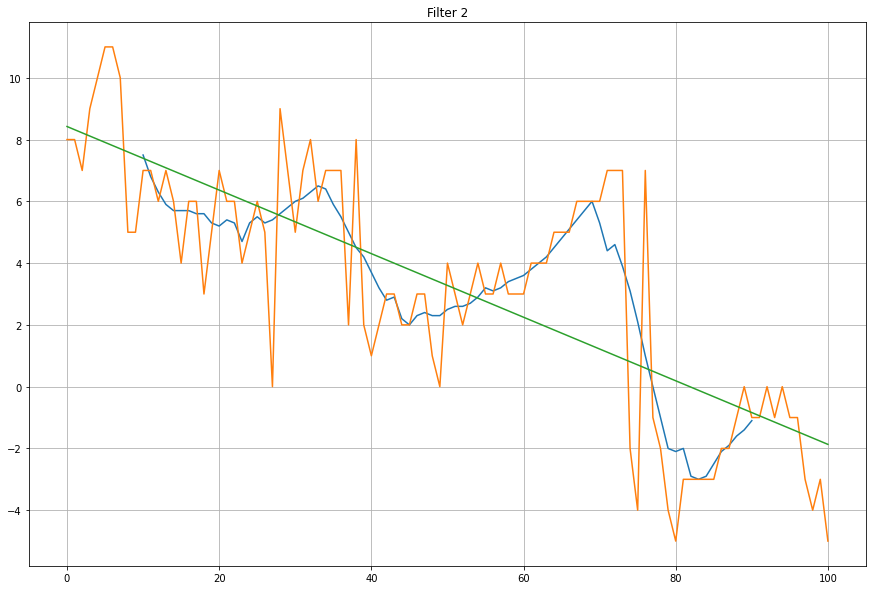

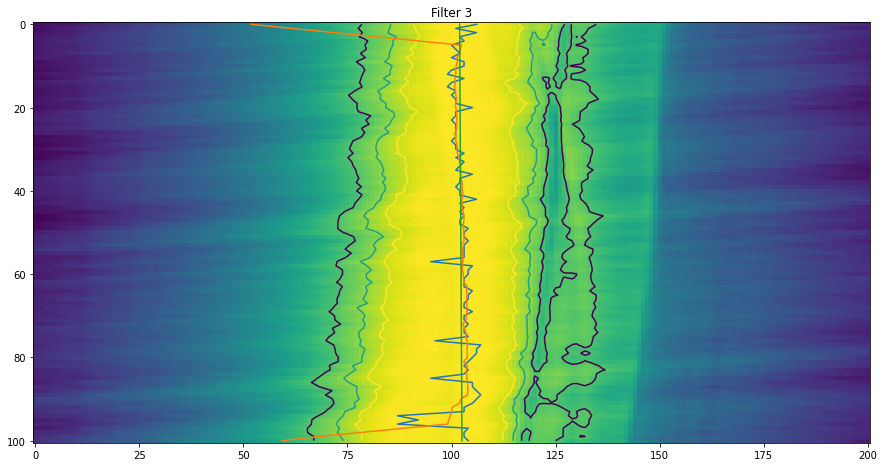

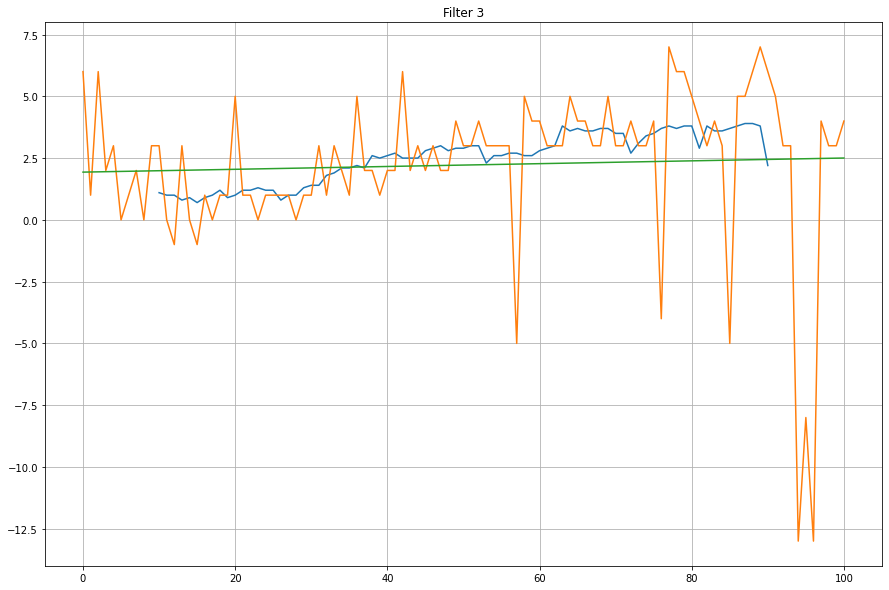

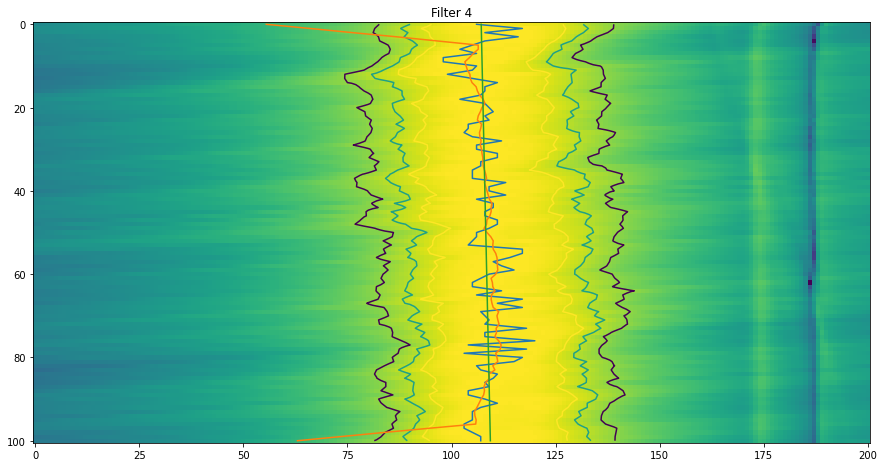

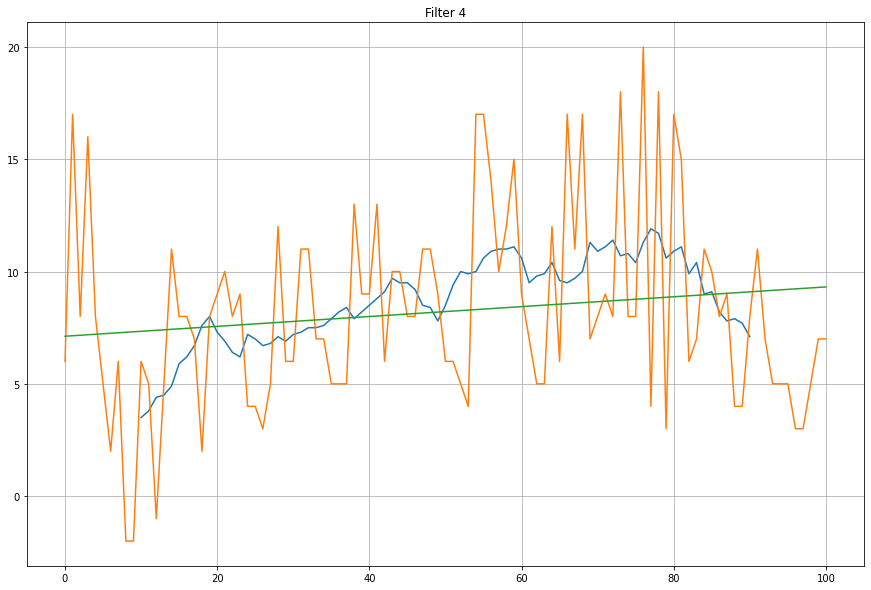

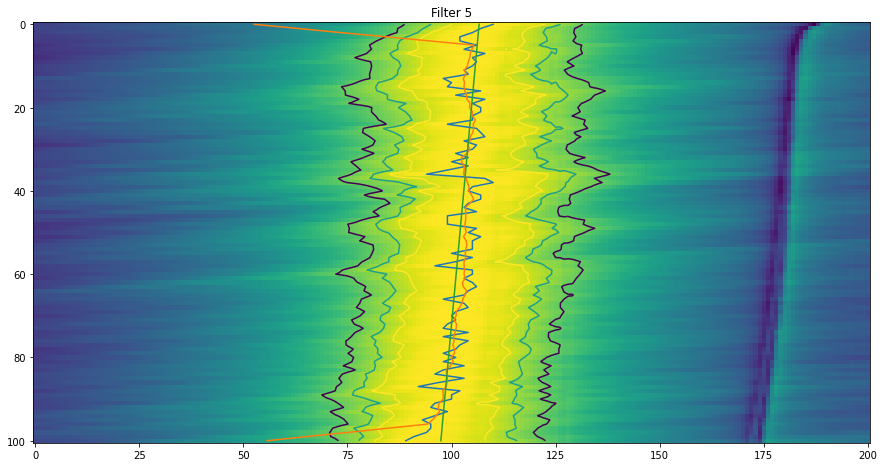

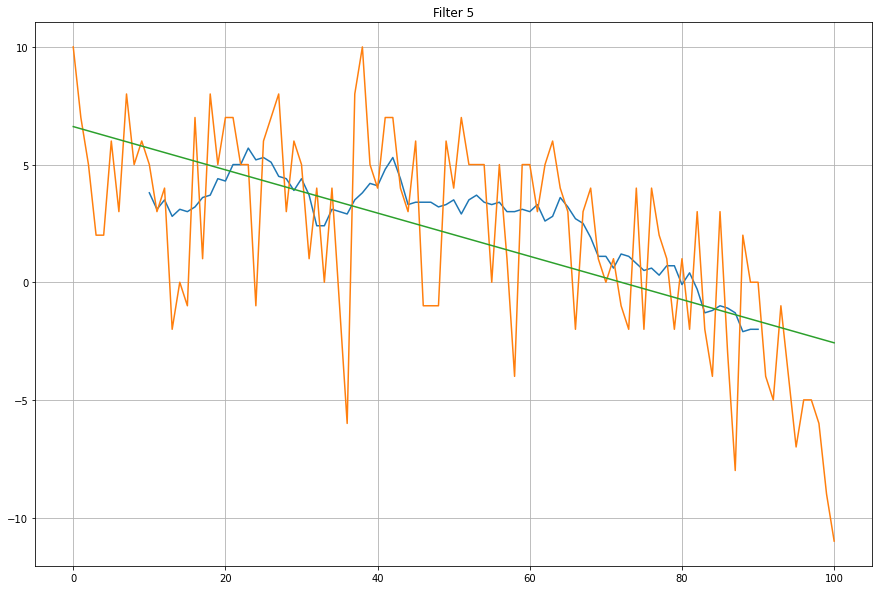

In [13]:
ftm = loadData('coarse_tuning_fine_measurements')

def dB(data):
    return 20*np.log10(np.abs(data))

def fineTuneAnalysis(meas, i):
    baseKey='filter%d'%(i)
    filterMap = meas[baseKey+'Map']
    tuningWords = meas[baseKey+'TuningWords'][0]
    frequencies = meas[baseKey+'Frequencies'][0]
    spanMap = meas[baseKey+'SpanMap']
    dBFilt=dB(filterMap)
    peaksIdx=np.argmax(dB(filterMap),axis=1)
    peaksVal=np.max(dB(filterMap),axis=1)
    
    x = np.arange(peaksIdx.shape[0])
    bestLineCoeff=np.polyfit(x, peaksIdx-100, deg=1)
    k, m =bestLineCoeff
    
    span=spanMap[0]
    deltaF=(max(span)-min(span))/float(len(span)-1)
    deltaW =(max(tuningWords)-min(tuningWords))/float(len(tuningWords)-1)
    
    kcorr=k*(deltaF/1e6)*(1/deltaW)
    mcorr=m*deltaF/1e6
    lineFunc=np.poly1d(bestLineCoeff)
    
   
    filterNorm = (dBFilt.T-peaksVal).T;
    plt.figure();
    plt.title("Filter %d"%(i))
    
    plt.imshow(filterNorm)
    
    yr = np.array(range(filterMap.shape[0]))
    
    
    plt.plot(peaksIdx, yr)
    peaksIdxFilter=np.convolve(peaksIdx, np.ones((10,))/10, mode='same')
   
    plt.plot(peaksIdxFilter, yr)
    plt.plot(lineFunc(x)+100,x)
    plt.contour(filterNorm, [-10, -6, -3])
    plt.figure()
    plt.title("Filter %d"%(i))
    plt.plot(np.arange(10,91), peaksIdxFilter[10:-10]-100)
    plt.plot(peaksIdx-100)
    plt.grid(True)
    
   
   
    plt.plot(x, lineFunc(x))
    return kcorr, mcorr
    #plt.contourf(db(filterMap), []
  
coarseData = loadData('coarse_filter_parameters')

kcoarse = coarseData['k'][0]
mcoarse = coarseData['m'][0]    
kfine = kcoarse
mfine = mcoarse

for i in range(6):
    k, m = fineTuneAnalysis(ftm, i)
    print("filter",i,"Coarse k", kcoarse[i], "[MHZ/lsb]", "coarse m", mcoarse[i], "[MHz]")
    kfine[i] = kcoarse[i] + k
    mfine[i] = mcoarse[i] + m
    print("filter",i,"fine   k", kfine[i], "[MHZ/lsb]", "cfine  m", mfine[i], "[MHz]")
    
fineTuned={'k':kfine, 'm':mfine}
saveData('fine_filter_parameters', fineTuned)

## Check fine tuned parameters

In [14]:
a = loadData('fine_filter_parameters')

ks = a['k'][0]
ms = a['m'][0]
filterBank = []
for i in range(len(ks)):
    filterBank.append(yig_controller_test.YigFilter(fMin[i], fMax[i], ms[i]*1e6, ks[i]*1e6, yc, i))
    
calMeas = skrf.network.Network('cal_through.s2p')

fix = yig_filter_model.SimpleS21Fixture(calMeas.f, calMeas.s[:, 1, 0])

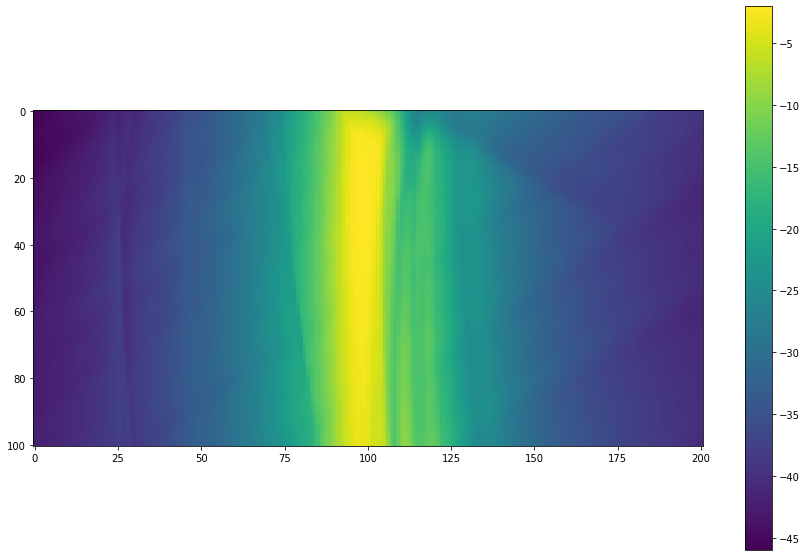

In [15]:
filter0Map, filter0TuningWords, filter0Frequencies, filter0SpanMap = measureYigFilter(filterBank[0])

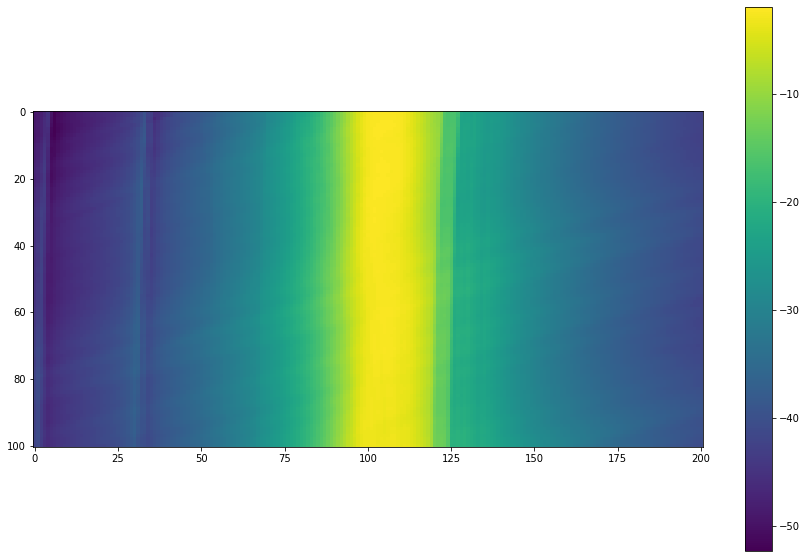

In [16]:
filter1Map, filter1TuningWords, filter1Frequencies, filter1SpanMap = measureYigFilter(filterBank[1])

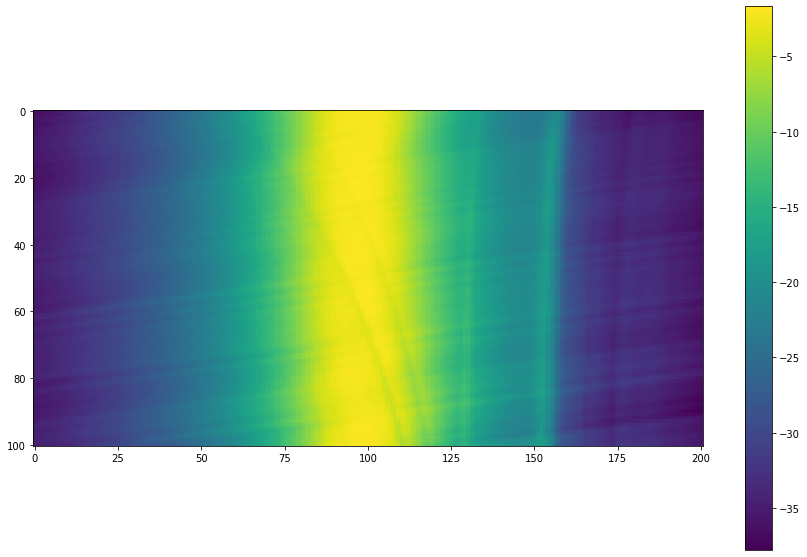

In [17]:
filter2Map, filter2TuningWords, filter2Frequencies, filter2SpanMap = measureYigFilter(filterBank[2])

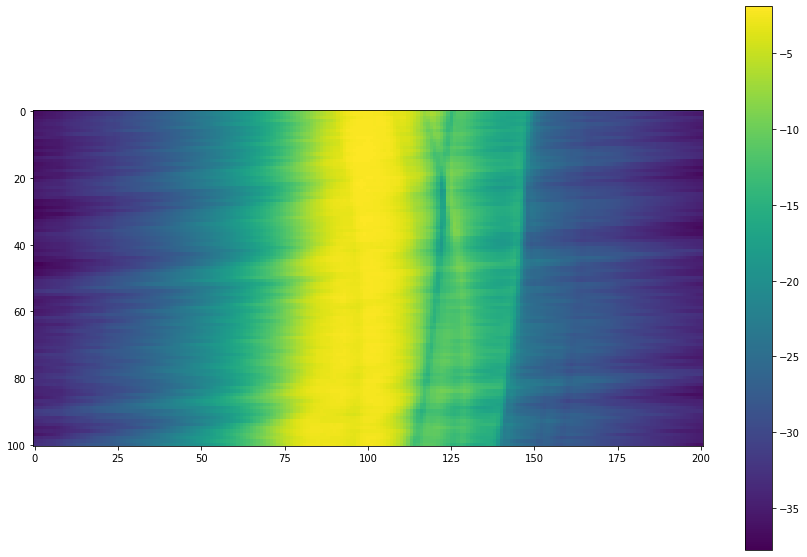

In [18]:
filter3Map, filter3TuningWords, filter3Frequencies, filter3SpanMap = measureYigFilter(filterBank[3])

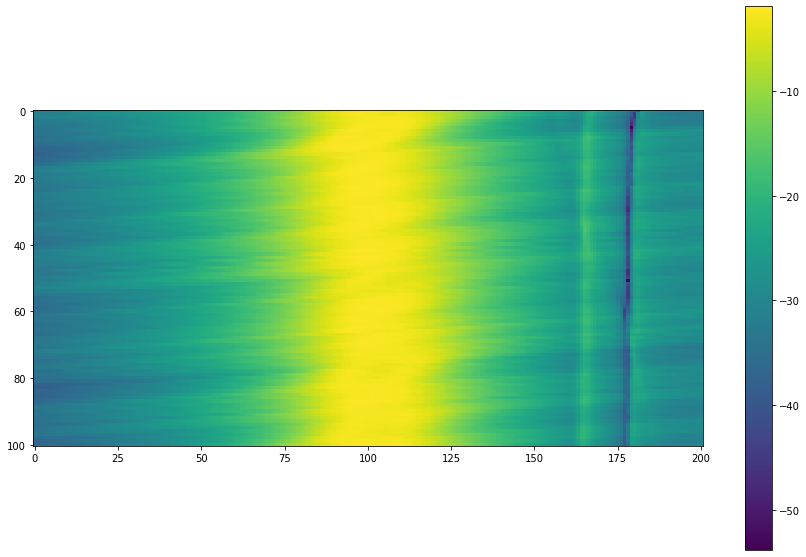

In [19]:
filter4Map, filter4TuningWords, filter4Frequencies, filter4SpanMap = measureYigFilter(filterBank[4])

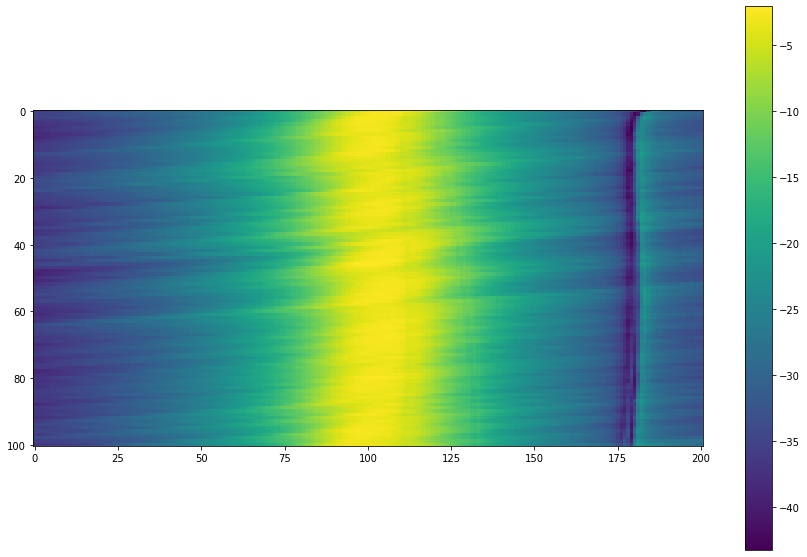

In [20]:
filter5Map, filter5TuningWords, filter5Frequencies, filter5SpanMap = measureYigFilter(filterBank[5])

In [21]:
saveDict={'filter0Map':filter0Map, 'filter0TuningWords':filter0TuningWords, 'filter0Frequencies':filter0Frequencies, 'filter0SpanMap':filter0SpanMap, 
          'filter1Map':filter1Map, 'filter1TuningWords':filter1TuningWords, 'filter1Frequencies':filter1Frequencies, 'filter1SpanMap':filter1SpanMap, 
          'filter2Map':filter2Map, 'filter2TuningWords':filter2TuningWords, 'filter2Frequencies':filter2Frequencies, 'filter2SpanMap':filter2SpanMap, 
          'filter3Map':filter3Map, 'filter3TuningWords':filter3TuningWords, 'filter3Frequencies':filter3Frequencies, 'filter3SpanMap':filter3SpanMap, 
          'filter4Map':filter4Map, 'filter4TuningWords':filter4TuningWords, 'filter4Frequencies':filter4Frequencies, 'filter4SpanMap':filter4SpanMap, 
          'filter5Map':filter5Map, 'filter5TuningWords':filter5TuningWords, 'filter5Frequencies':filter5Frequencies, 'filter5SpanMap':filter5SpanMap, }
saveData('fine_tuning_fine_measurements', saveDict)

filter 0 Coarse k 0.023034627243764066 [MHZ/lsb] coarse m 704.3939573926987 [MHz]
filter 0 fine   k 0.023032279487774397 [MHZ/lsb] cfine  m 700.0826586157622 [MHz]
filter 1 Coarse k 0.07282484605642375 [MHZ/lsb] coarse m 1970.6741649540672 [MHz]
filter 1 fine   k 0.07294298262908877 [MHZ/lsb] cfine  m 1978.5760286698505 [MHz]
filter 2 Coarse k 0.08362027713551867 [MHZ/lsb] coarse m 2276.4698649839006 [MHz]
filter 2 fine   k 0.0836711714521552 [MHZ/lsb] cfine  m 2272.0741165855316 [MHz]
filter 3 Coarse k 0.16613543713831988 [MHZ/lsb] coarse m 4477.160203141481 [MHz]
filter 3 fine   k 0.16613894476506155 [MHZ/lsb] cfine  m 4476.152631796112 [MHz]
filter 4 Coarse k 0.32862568442880835 [MHZ/lsb] coarse m 8898.705759672932 [MHz]
filter 4 fine   k 0.32857376460851506 [MHZ/lsb] cfine  m 8899.046470214575 [MHz]
filter 5 Coarse k 0.3881885354619618 [MHZ/lsb] coarse m 10520.738265184726 [MHz]
filter 5 fine   k 0.38807859856856475 [MHZ/lsb] cfine  m 10528.804660059508 [MHz]


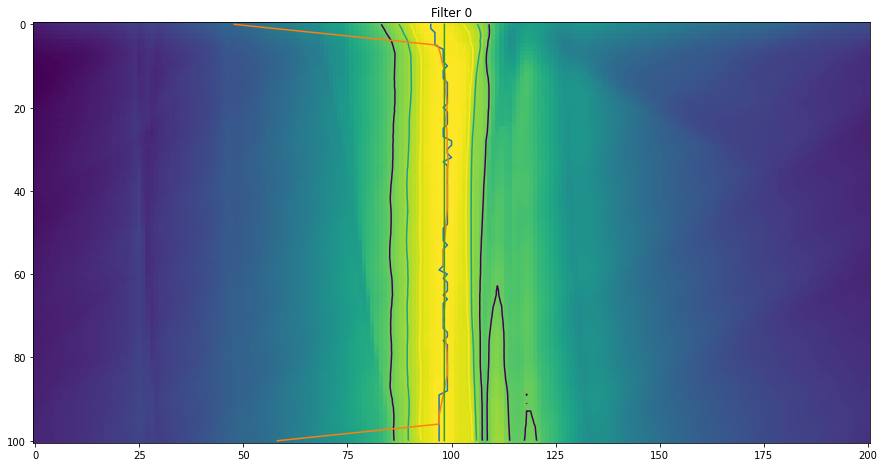

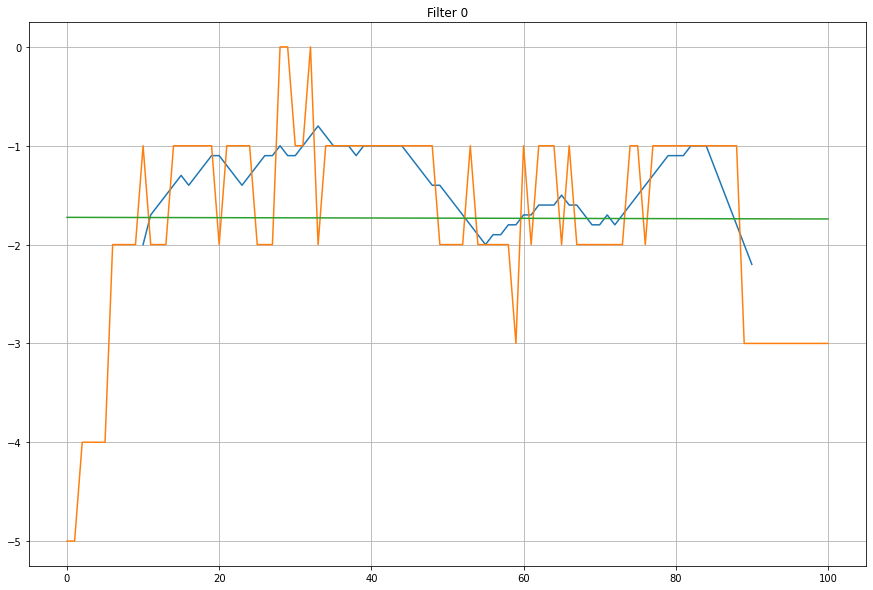

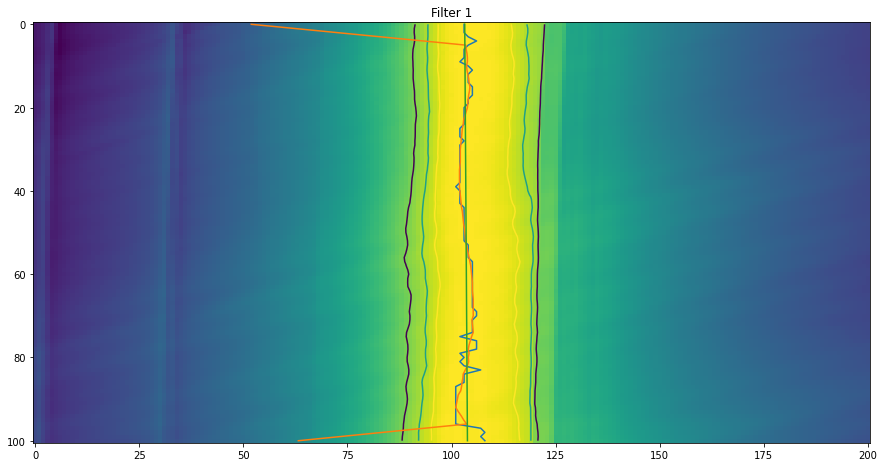

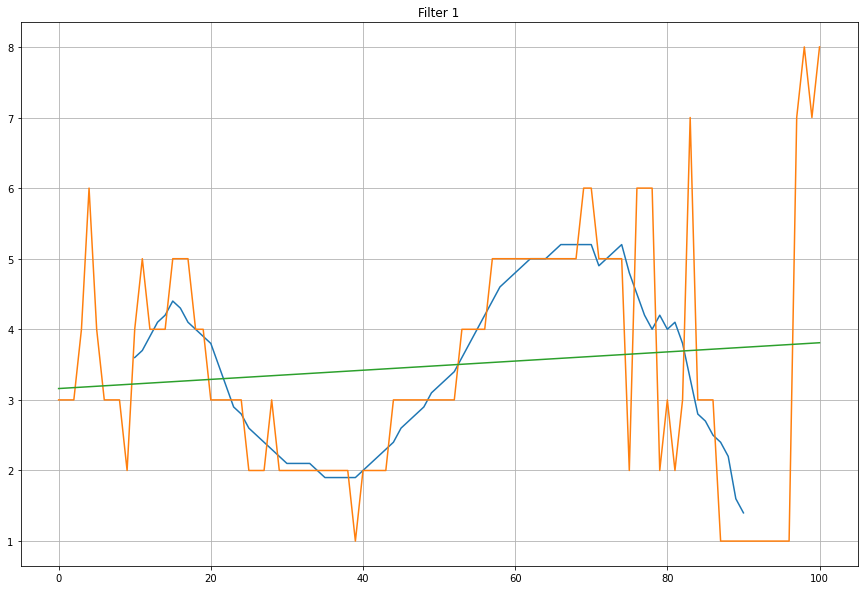

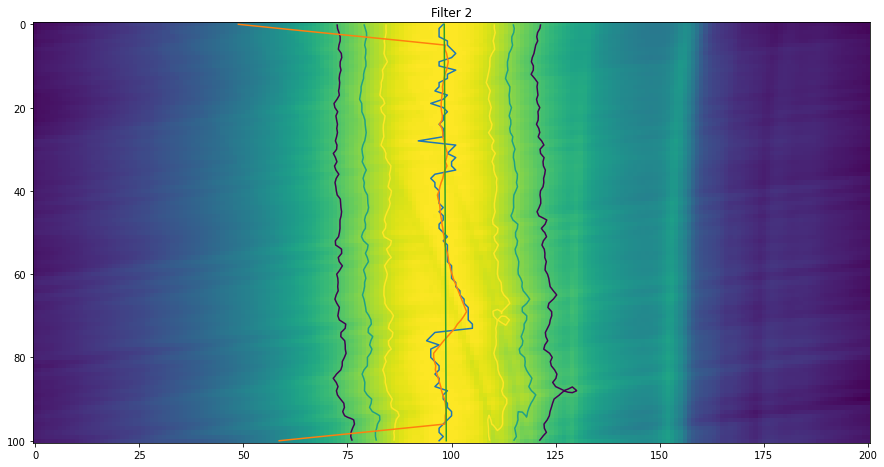

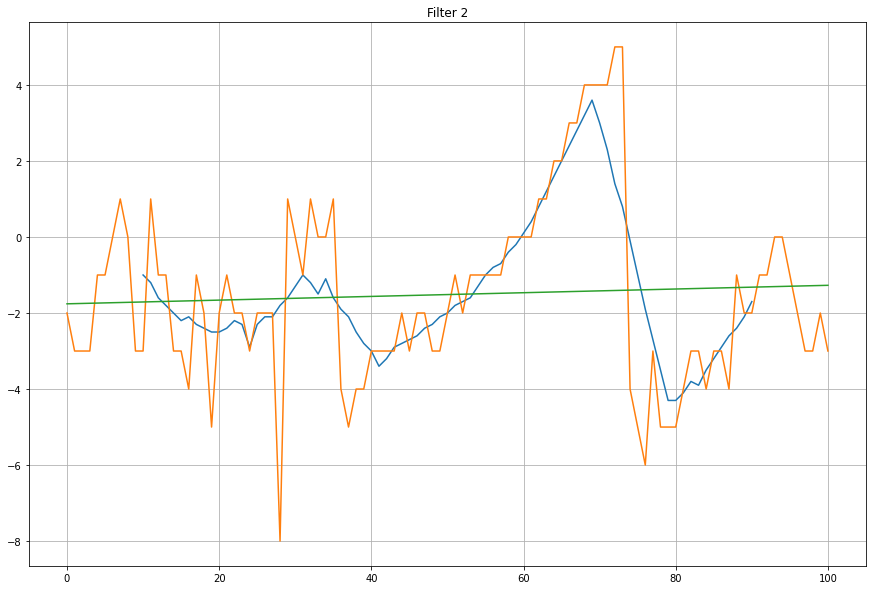

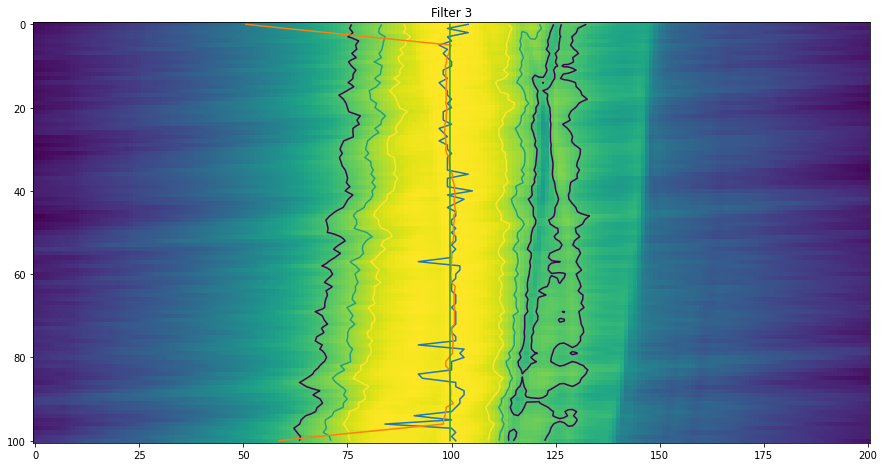

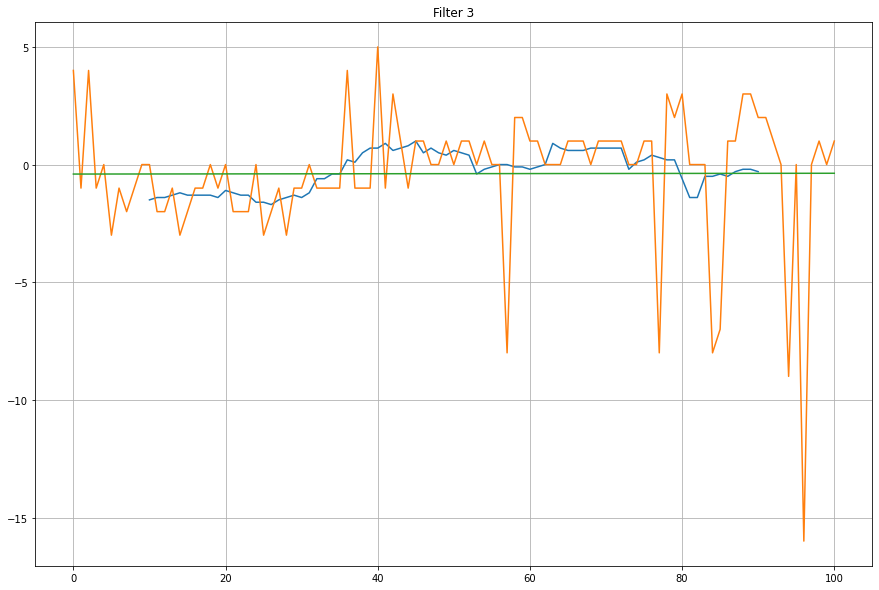

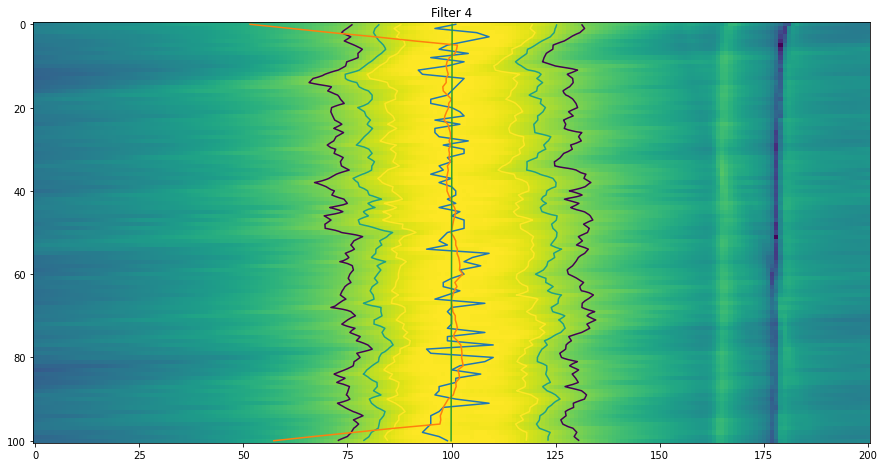

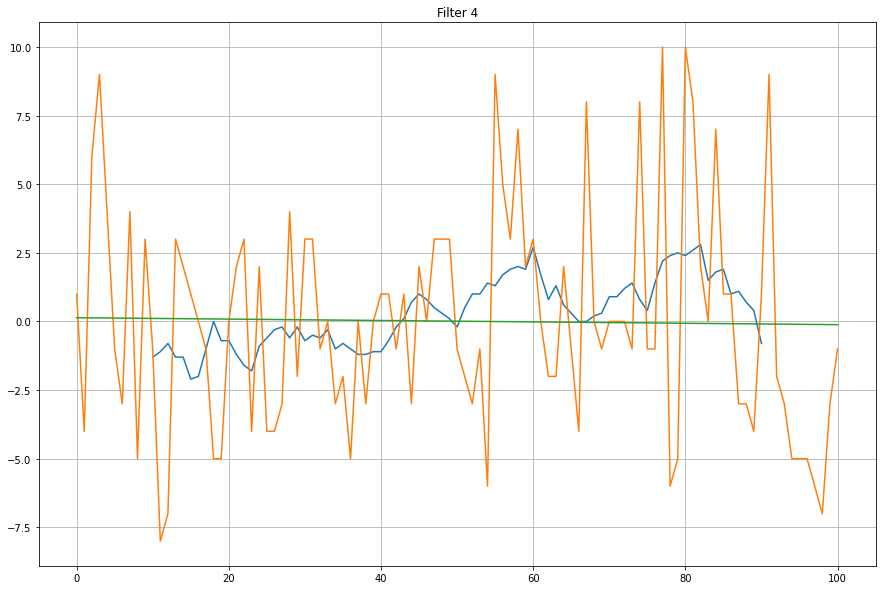

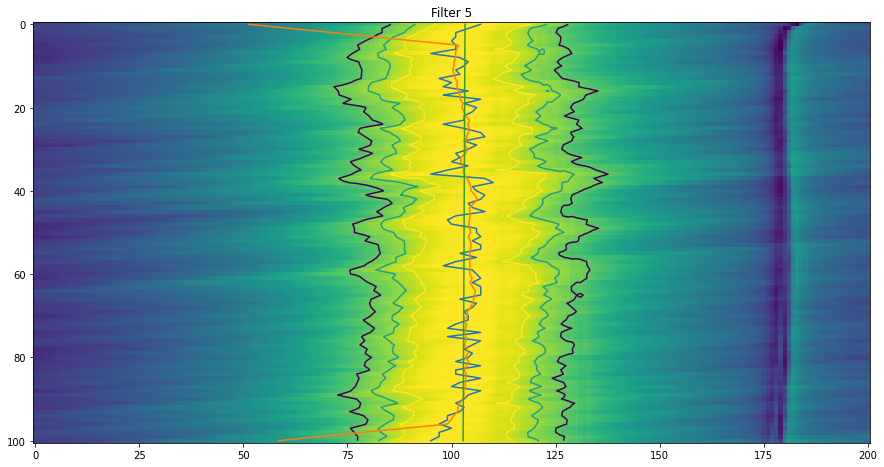

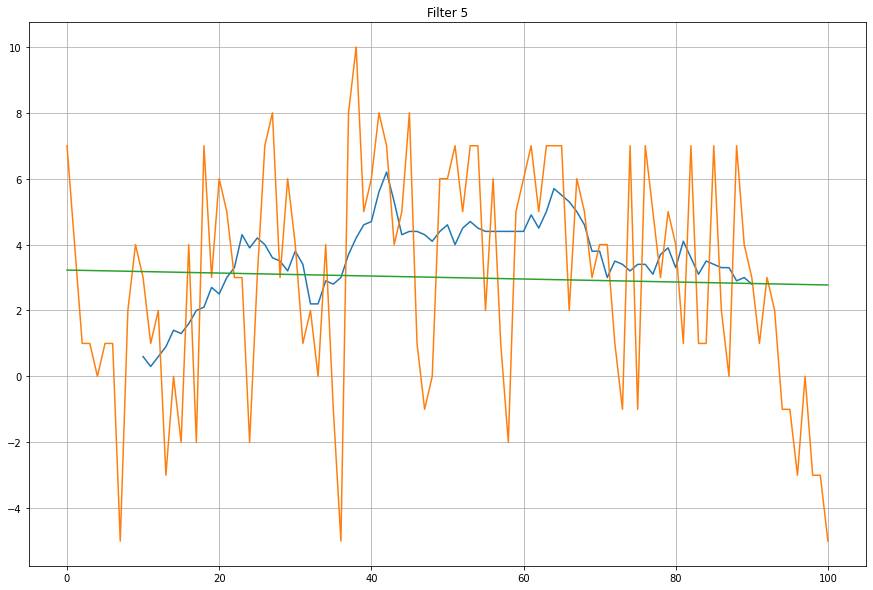

In [22]:
ftm = loadData('fine_tuning_fine_measurements')

coarseData = loadData('fine_filter_parameters')

kcoarse = coarseData['k'][0]
mcoarse = coarseData['m'][0]    
kfine = kcoarse
mfine = mcoarse

for i in range(6):
    k, m = fineTuneAnalysis(ftm, i)
    print("filter",i,"Coarse k", kcoarse[i], "[MHZ/lsb]", "coarse m", mcoarse[i], "[MHz]")
    kfine[i] = kcoarse[i] + k
    mfine[i] = mcoarse[i] + m
    print("filter",i,"fine   k", kfine[i], "[MHZ/lsb]", "cfine  m", mfine[i], "[MHz]")
    
fineTuned={'k':kfine, 'm':mfine}
#saveData('fine_filter_parameters', fineTuned)

## Cross coupling 

In [4]:
a = loadData('fine_filter_parameters')

ks = a['k'][0]
ms = a['m'][0]
#filterBank = []
for i in range(len(ks)):
    print
    yigDriver.writeFilterSlope(i, ks[i]*1e6)
    time.sleep(0.2)
    yigDriver.writeFilterOffset(i, ms[i]*1e6)
    time.sleep(0.2)
    yigDriver.writeFilterLowLim(i, fMin[i])
    time.sleep(0.2)
    yigDriver.writeFilterHighLim(i, fMax[i])
    time.sleep(0.2)
    print(yigDriver.dev.read())
yigDriver.save()
time.sleep(0.2)
    #filterBank.append(yig_controller_test.YigFilter(fMin[i], fMax[i], ms[i]*1e6, ks[i]*1e6, yc, i))
    
#fc = 0.7e9
#spanHalf=500e6/2;
#vna.setStartFrequency(fc-spanHalf)
#vna.setStopFrequency(fc+spanHalf)
#filterBank[0].tuneTo(fc, channel=yigDriver)
#switch.set(1)
#vna.readSParameter('S21')
#yc.yigA.set(6,32700)

Writing=> COEF A S 0 23166.387840

Writing=> COEF A O 0 702557621.825849

Writing=> COEF A L 0 600000000.000000

Writing=> COEF A H 0 1000000000.000000

Read<= O
b'O'
Writing=> COEF A S 1 73009.400918

Writing=> COEF A O 1 1994743077.338501

Writing=> COEF A L 1 1000000000.000000

Writing=> COEF A H 1 2000000000.000000

Read<= K
b'K'
Writing=> COEF A S 2 83846.365495

Writing=> COEF A O 2 2301726862.125820

Writing=> COEF A L 2 2000000000.000000

Writing=> COEF A H 2 4000000000.000000

Read<= 
b'\r'
Writing=> COEF A S 3 166157.437701

Writing=> COEF A O 3 4527867607.235598

Writing=> COEF A L 3 4000000000.000000

Writing=> COEF A H 3 8000000000.000000

Read<= 

b'\n'
Writing=> COEF A S 4 329062.820568

Writing=> COEF A O 4 8993601756.995855

Writing=> COEF A L 4 8000000000.000000

Writing=> COEF A H 4 12000000000.000000

Read<= O
b'O'
Writing=> COEF A S 5 388547.689275

Writing=> COEF A O 5 10644889305.369188

Writing=> COEF A L 5 12000000000.000000

Writing=> COEF A H 5 16000000000.00